# Convert Raw Accelerometer Data to Minutely Step Counts

This notebook uses the forest oak algorithm (ported to Python) to compute step counts
from raw accelerometer data at minutely granularity.

The algorithm:
1. Resamples accelerometer data to 10 Hz
2. Computes gravity-corrected vector magnitude
3. Uses Continuous Wavelet Transform (CWT) to identify walking bouts
4. Calculates per-second cadence (step frequency in 1.4-2.3 Hz range)
5. Aggregates to minutely totals


In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
SRC_PATH = Path('/n/home01/egraff/sample_imputation/src')
if str(SRC_PATH) not in sys.path:
    sys.path.append(str(SRC_PATH))

from steps.oak import compute_steps_minutely

DATA_ROOT = Path('/n/home01/egraff/sample_imputation/data/raw')
SUBJECT_IDS = sorted(
    d.name for d in DATA_ROOT.iterdir()
    if d.is_dir() and d.name != '__MACOSX'
)

if not SUBJECT_IDS:
    raise FileNotFoundError(f'No participant directories found in {DATA_ROOT}')

print(f'Found {len(SUBJECT_IDS)} participants: {", ".join(SUBJECT_IDS)}')


Found 6 participants: 3si9xdvl, bn4j8yj9, gq36edfi, ubrmuu2r, xwyd72l9, zg5uqa5l


## Helper Functions


In [2]:
def subject_csv_files(subject_id: str) -> list[Path]:
    """Get all accelerometer CSV files for a subject."""
    accel_dir = DATA_ROOT / subject_id / 'accelerometer'
    if not accel_dir.exists():
        raise FileNotFoundError(f'Accelerometer directory not found for {subject_id}: {accel_dir}')

    files = sorted(accel_dir.glob('*.csv'))
    if not files:
        raise FileNotFoundError(f'No accelerometer CSV files found in {accel_dir}')
    return files


def load_hourly_dataframe(fp: Path) -> pd.DataFrame:
    """Load a single hourly accelerometer CSV file."""
    hourly = pd.read_csv(fp, usecols=['timestamp', 'x', 'y', 'z'])
    hourly['timestamp'] = pd.to_datetime(hourly['timestamp'], unit='ms', utc=True)
    return hourly


def load_subject_data(subject_id: str) -> pd.DataFrame:
    """Load and concatenate all accelerometer data for a subject."""
    files = subject_csv_files(subject_id)
    print(f'  Found {len(files)} hourly CSV files.')
    
    hourly_frames = [load_hourly_dataframe(fp) for fp in files]
    raw_df = (
        pd.concat(hourly_frames, ignore_index=True)
        .sort_values('timestamp')
        .drop_duplicates(subset='timestamp', keep='first')
        .reset_index(drop=True)
    )
    
    print(
        f'  Aggregated {len(raw_df):,} samples spanning '
        f"{raw_df['timestamp'].min()} to {raw_df['timestamp'].max()} UTC"
    )
    return raw_df


## Compute Minutely Step Counts for All Participants


In [3]:
subject_steps: dict[str, pd.DataFrame] = {}

for subject_id in SUBJECT_IDS:
    print(f'\nProcessing {subject_id}...')
    
    # Load raw accelerometer data
    raw_df = load_subject_data(subject_id)
    
    # Compute minutely step counts
    steps_minutely = compute_steps_minutely(
        raw_df[['timestamp', 'x', 'y', 'z']],
        tz_str='America/New_York'
    )
    
    print(f'  Generated {len(steps_minutely):,} minutely step epochs.')
    
    if steps_minutely.empty:
        print('  No step epochs available; skipping.')
        continue
    
    subject_steps[subject_id] = steps_minutely.copy()
    
    # Summary statistics
    total_steps = steps_minutely['steps'].sum()
    total_walking_time = steps_minutely['walking_time'].sum()
    avg_cadence = steps_minutely.loc[steps_minutely['cadence'] > 0, 'cadence'].mean()
    
    print(f'  Total steps: {total_steps:,}')
    print(f'  Total walking time: {total_walking_time:,} seconds ({total_walking_time/60:.1f} minutes)')
    print(f'  Average cadence during walking: {avg_cadence:.2f} Hz ({avg_cadence*60:.1f} steps/min)' if not np.isnan(avg_cadence) else '  Average cadence: N/A')

print(f'\n\nProcessed {len(subject_steps)} participants with step data.')



Processing 3si9xdvl...
  Found 88 hourly CSV files.
  Aggregated 1,187,679 samples spanning 2022-03-21 13:45:45.465000+00:00 to 2022-03-28 05:25:58.813000+00:00 UTC


/n/home01/egraff/sample_imputation/src/steps/oak.py:529: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  t_minutes = t_series.dt.floor('T')


  Generated 9,581 minutely step epochs.
  Total steps: 10,617
  Total walking time: 6,010 seconds (100.2 minutes)
  Average cadence during walking: 1.82 Hz (109.4 steps/min)

Processing bn4j8yj9...
  Found 143 hourly CSV files.
  Aggregated 1,949,079 samples spanning 2022-03-21 12:49:53.707000+00:00 to 2022-03-29 00:59:59.928000+00:00 UTC


/n/home01/egraff/sample_imputation/src/steps/oak.py:529: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  t_minutes = t_series.dt.floor('T')


  Generated 10,811 minutely step epochs.
  Total steps: 13,159
  Total walking time: 6,513 seconds (108.5 minutes)
  Average cadence during walking: 1.96 Hz (117.4 steps/min)

Processing gq36edfi...
  Found 133 hourly CSV files.
  Aggregated 1,686,751 samples spanning 2022-03-22 03:43:26.433000+00:00 to 2022-03-29 00:59:59.936000+00:00 UTC


/n/home01/egraff/sample_imputation/src/steps/oak.py:529: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  t_minutes = t_series.dt.floor('T')


  Generated 9,917 minutely step epochs.
  Total steps: 12,441
  Total walking time: 7,295 seconds (121.6 minutes)
  Average cadence during walking: 1.78 Hz (106.9 steps/min)

Processing ubrmuu2r...
  Found 182 hourly CSV files.
  Aggregated 4,404,920 samples spanning 2022-03-21 11:17:13.593000+00:00 to 2022-03-29 00:59:59.871000+00:00 UTC


/n/home01/egraff/sample_imputation/src/steps/oak.py:529: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  t_minutes = t_series.dt.floor('T')


  Generated 10,903 minutely step epochs.
  Total steps: 15,748
  Total walking time: 9,029 seconds (150.5 minutes)
  Average cadence during walking: 1.78 Hz (107.0 steps/min)

Processing xwyd72l9...
  Found 193 hourly CSV files.
  Aggregated 2,085,490 samples spanning 2022-03-21 00:00:00.180000+00:00 to 2022-03-29 00:59:45.064000+00:00 UTC


/n/home01/egraff/sample_imputation/src/steps/oak.py:529: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  t_minutes = t_series.dt.floor('T')


  Generated 11,580 minutely step epochs.
  Total steps: 10,401
  Total walking time: 6,000 seconds (100.0 minutes)
  Average cadence during walking: 1.77 Hz (106.0 steps/min)

Processing zg5uqa5l...
  Found 163 hourly CSV files.
  Aggregated 2,307,051 samples spanning 2022-03-21 23:46:16.567000+00:00 to 2022-03-29 00:59:10.101000+00:00 UTC


/n/home01/egraff/sample_imputation/src/steps/oak.py:529: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  t_minutes = t_series.dt.floor('T')


  Generated 10,154 minutely step epochs.
  Total steps: 7,545
  Total walking time: 4,394 seconds (73.2 minutes)
  Average cadence during walking: 1.76 Hz (105.6 steps/min)


Processed 6 participants with step data.


## Plot Minutely Step Counts by Day



Plotting 3si9xdvl...


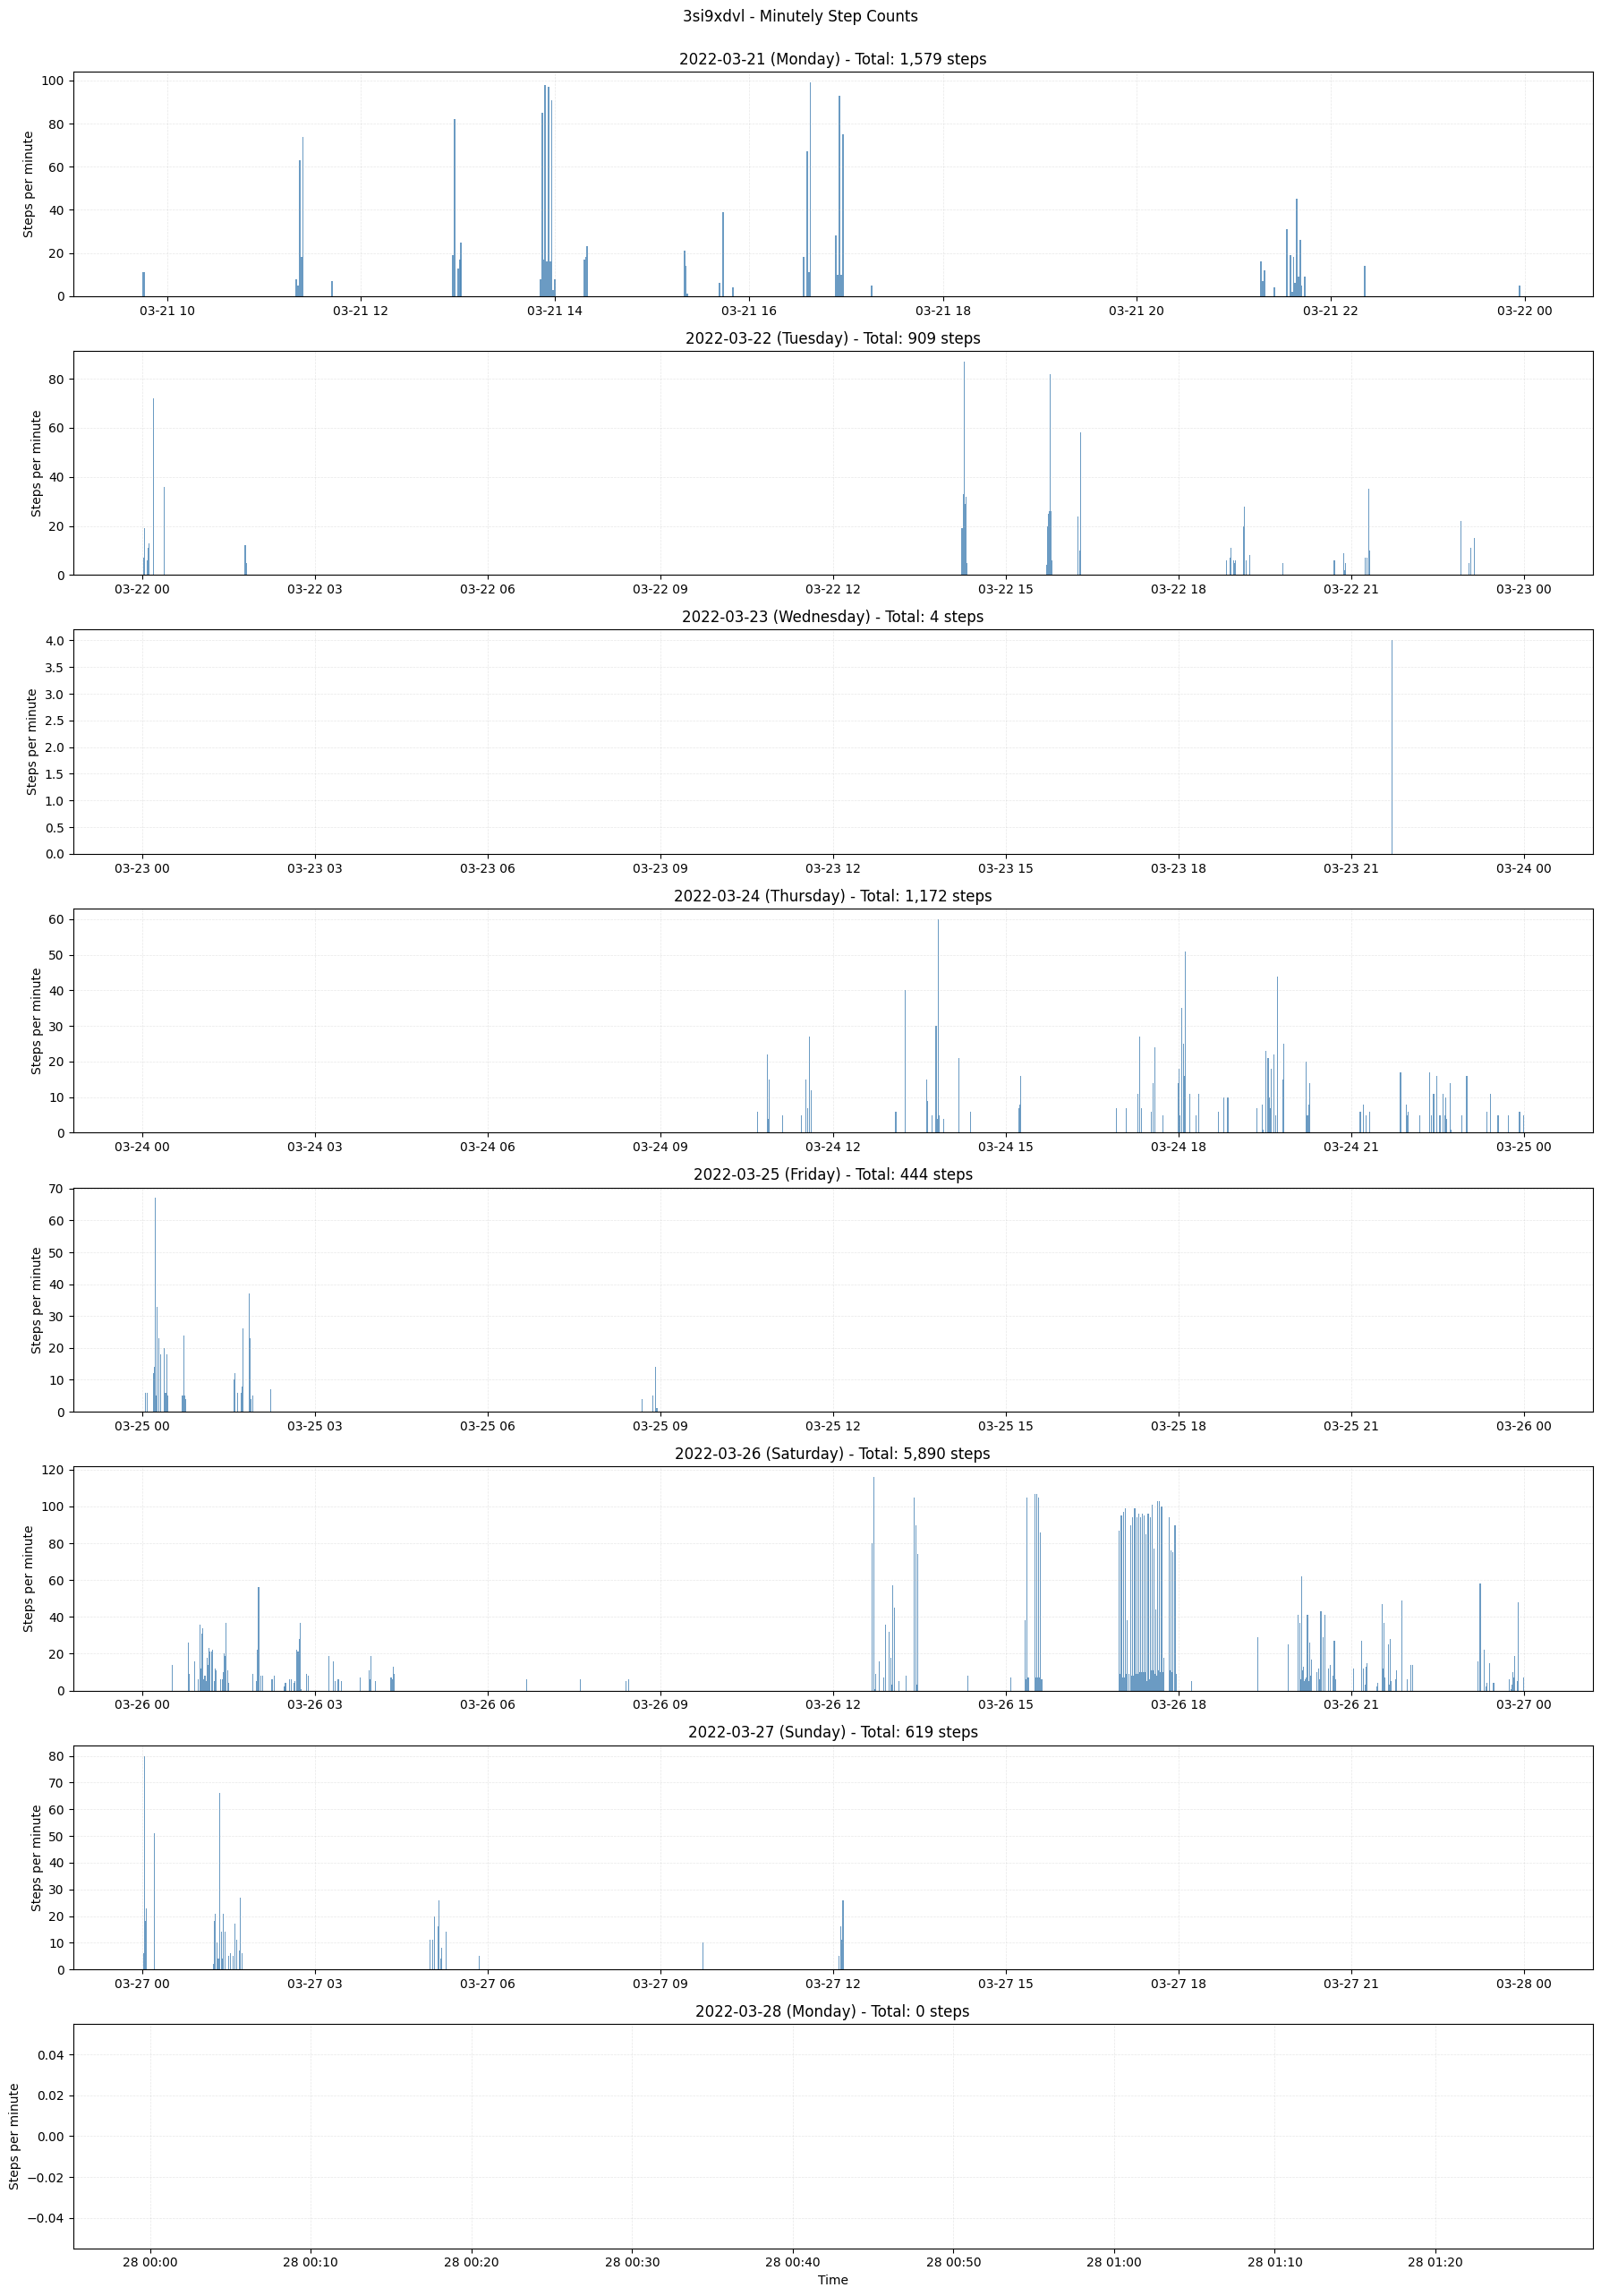


Plotting bn4j8yj9...


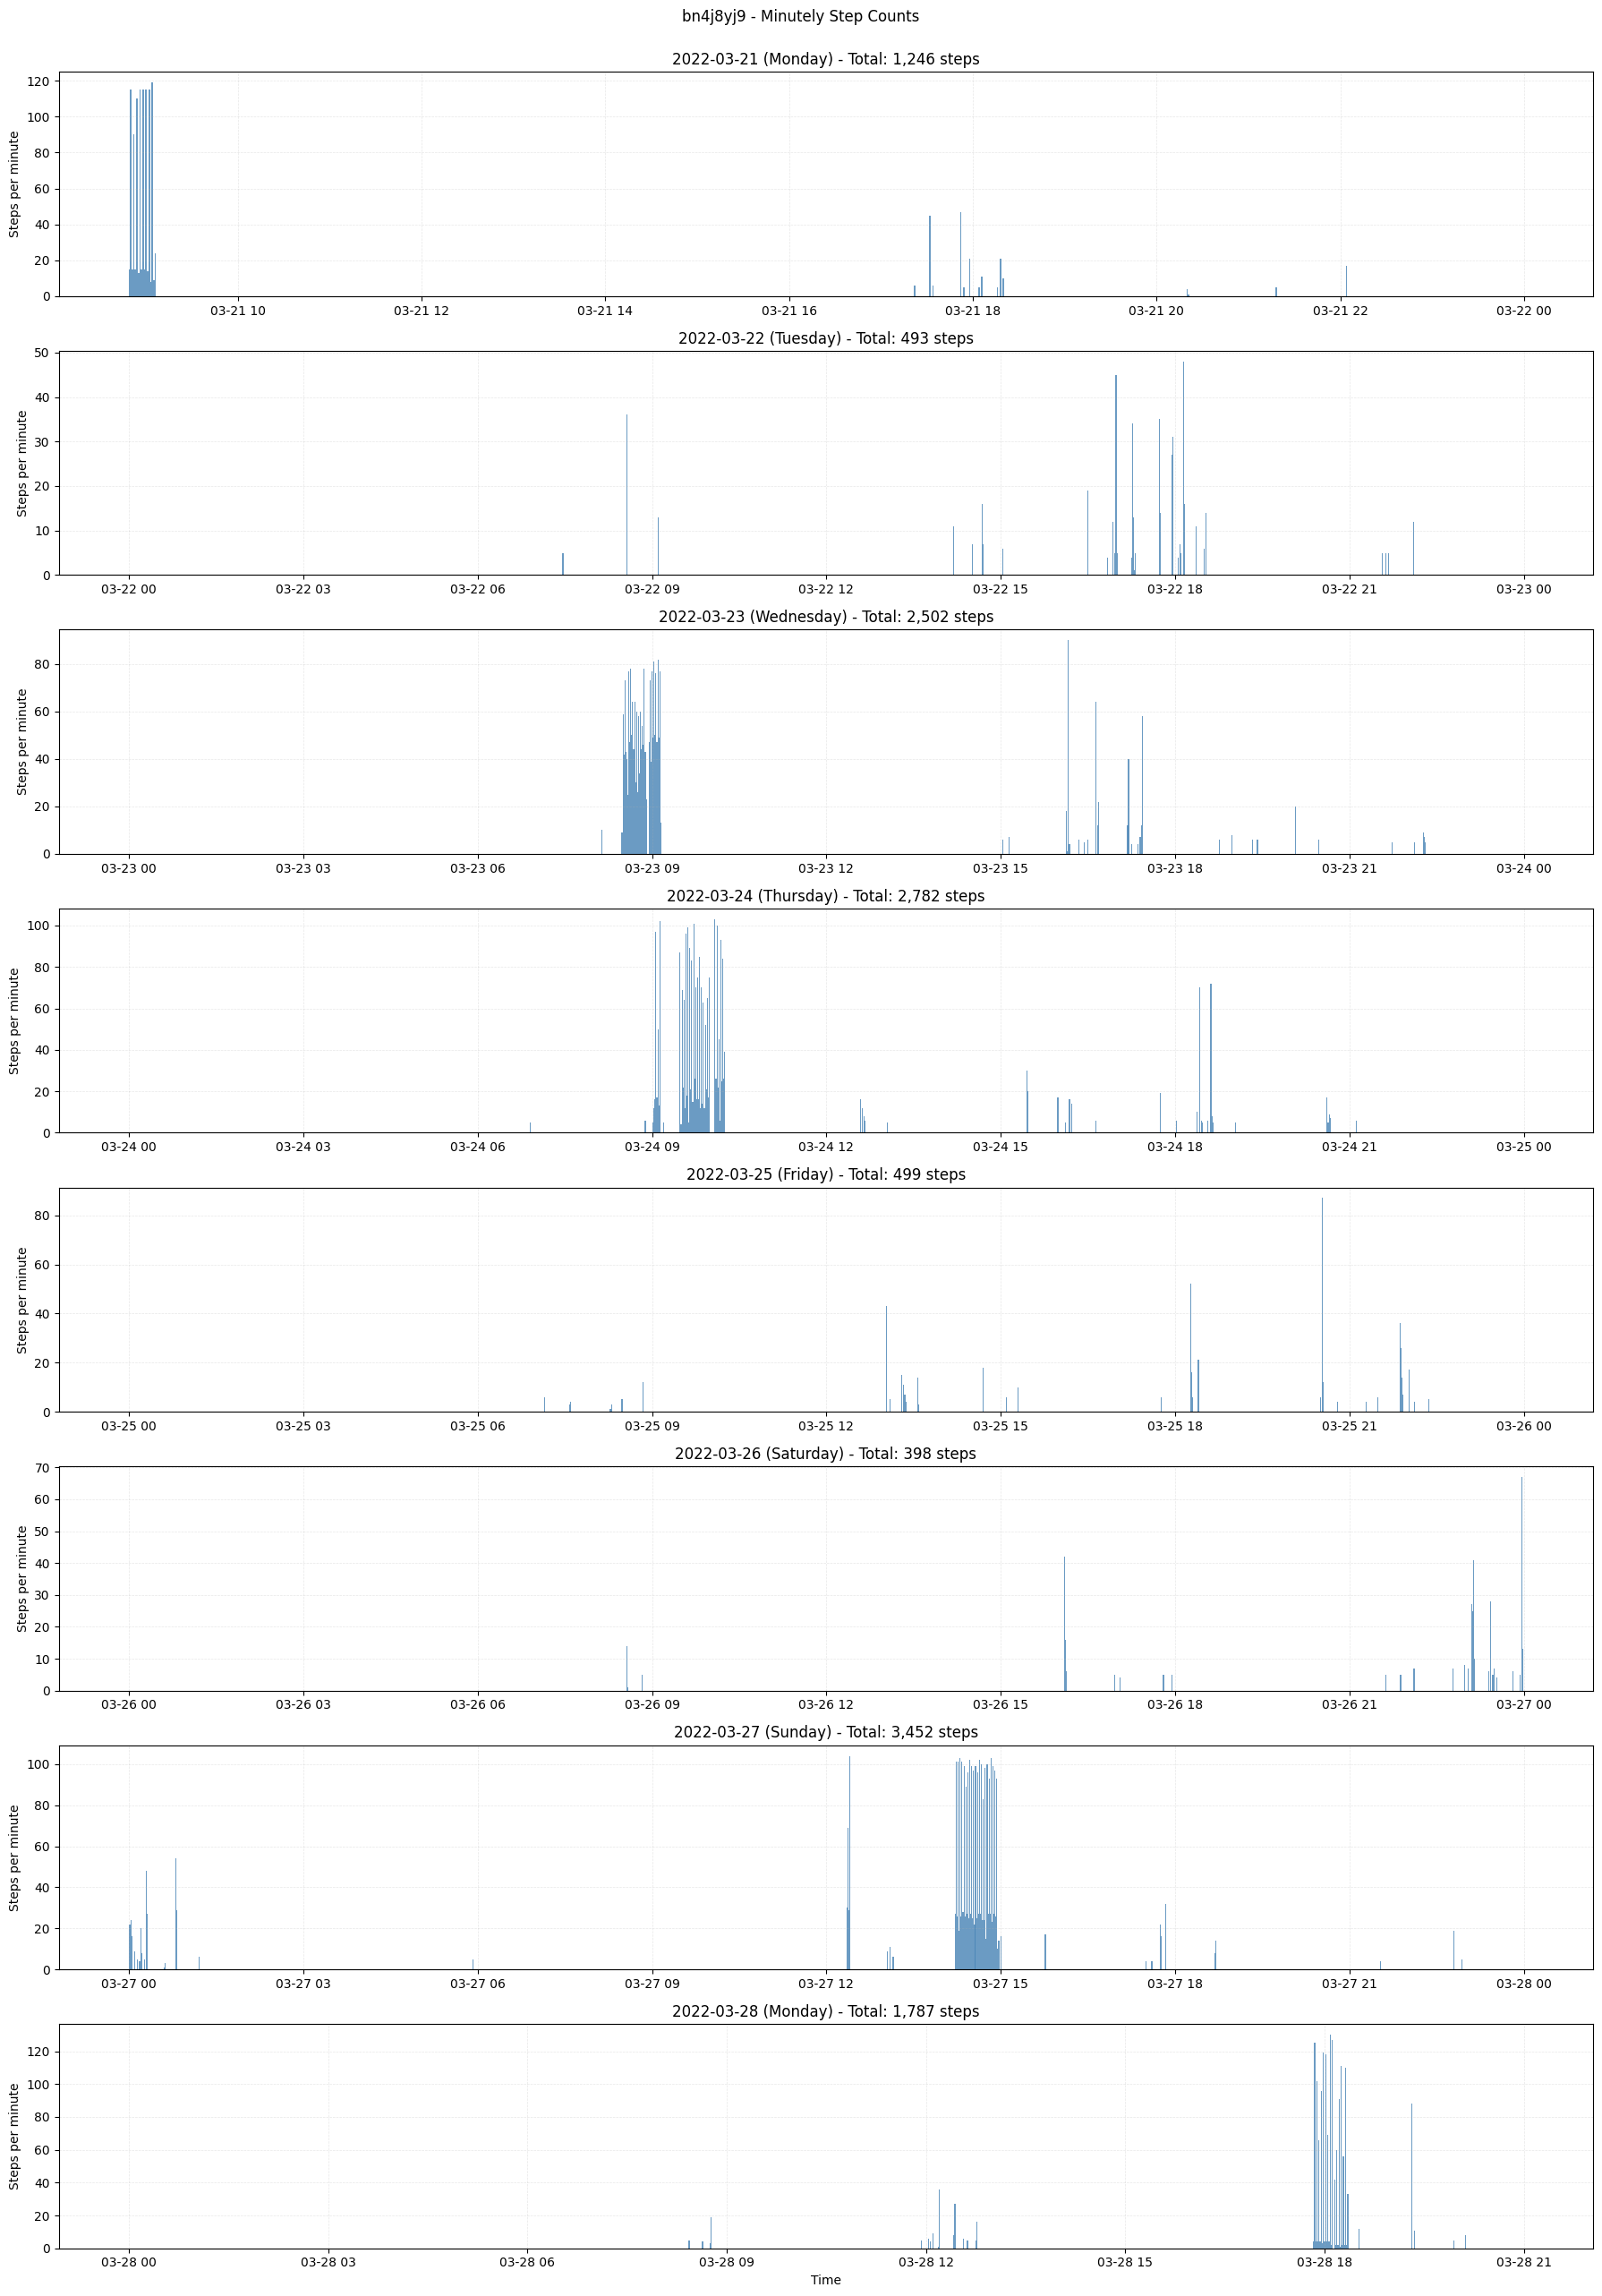


Plotting gq36edfi...


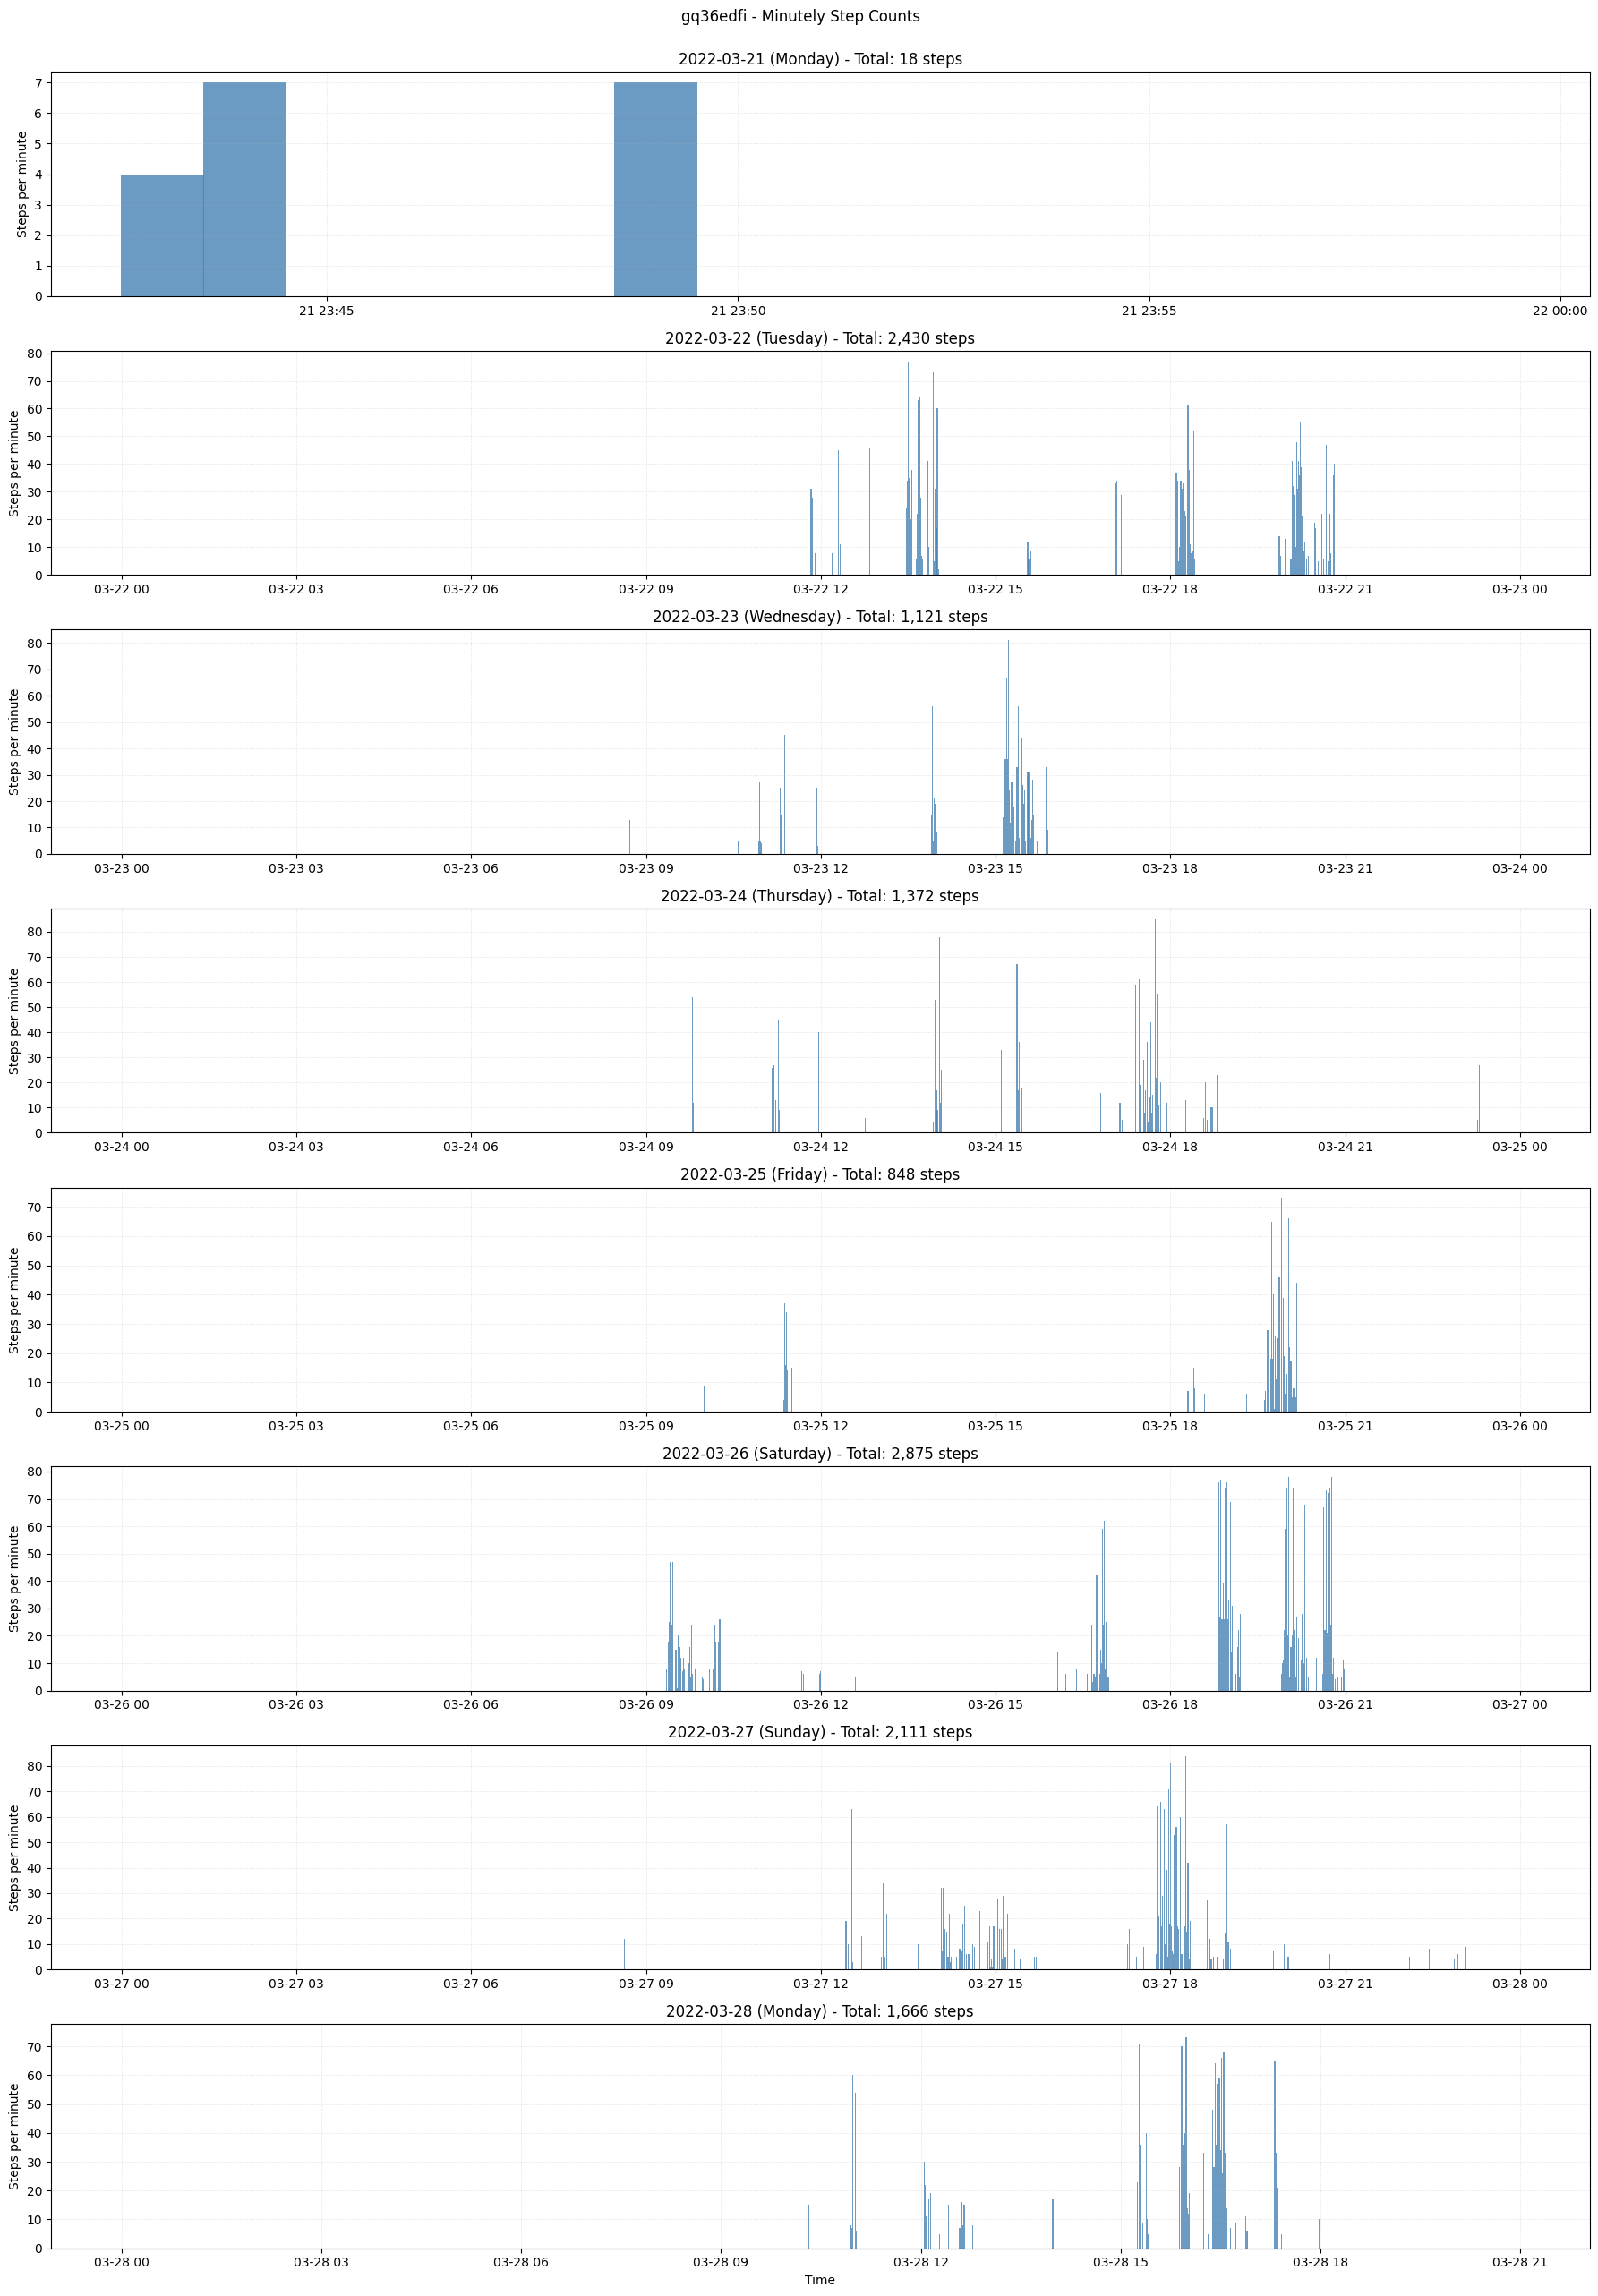


Plotting ubrmuu2r...


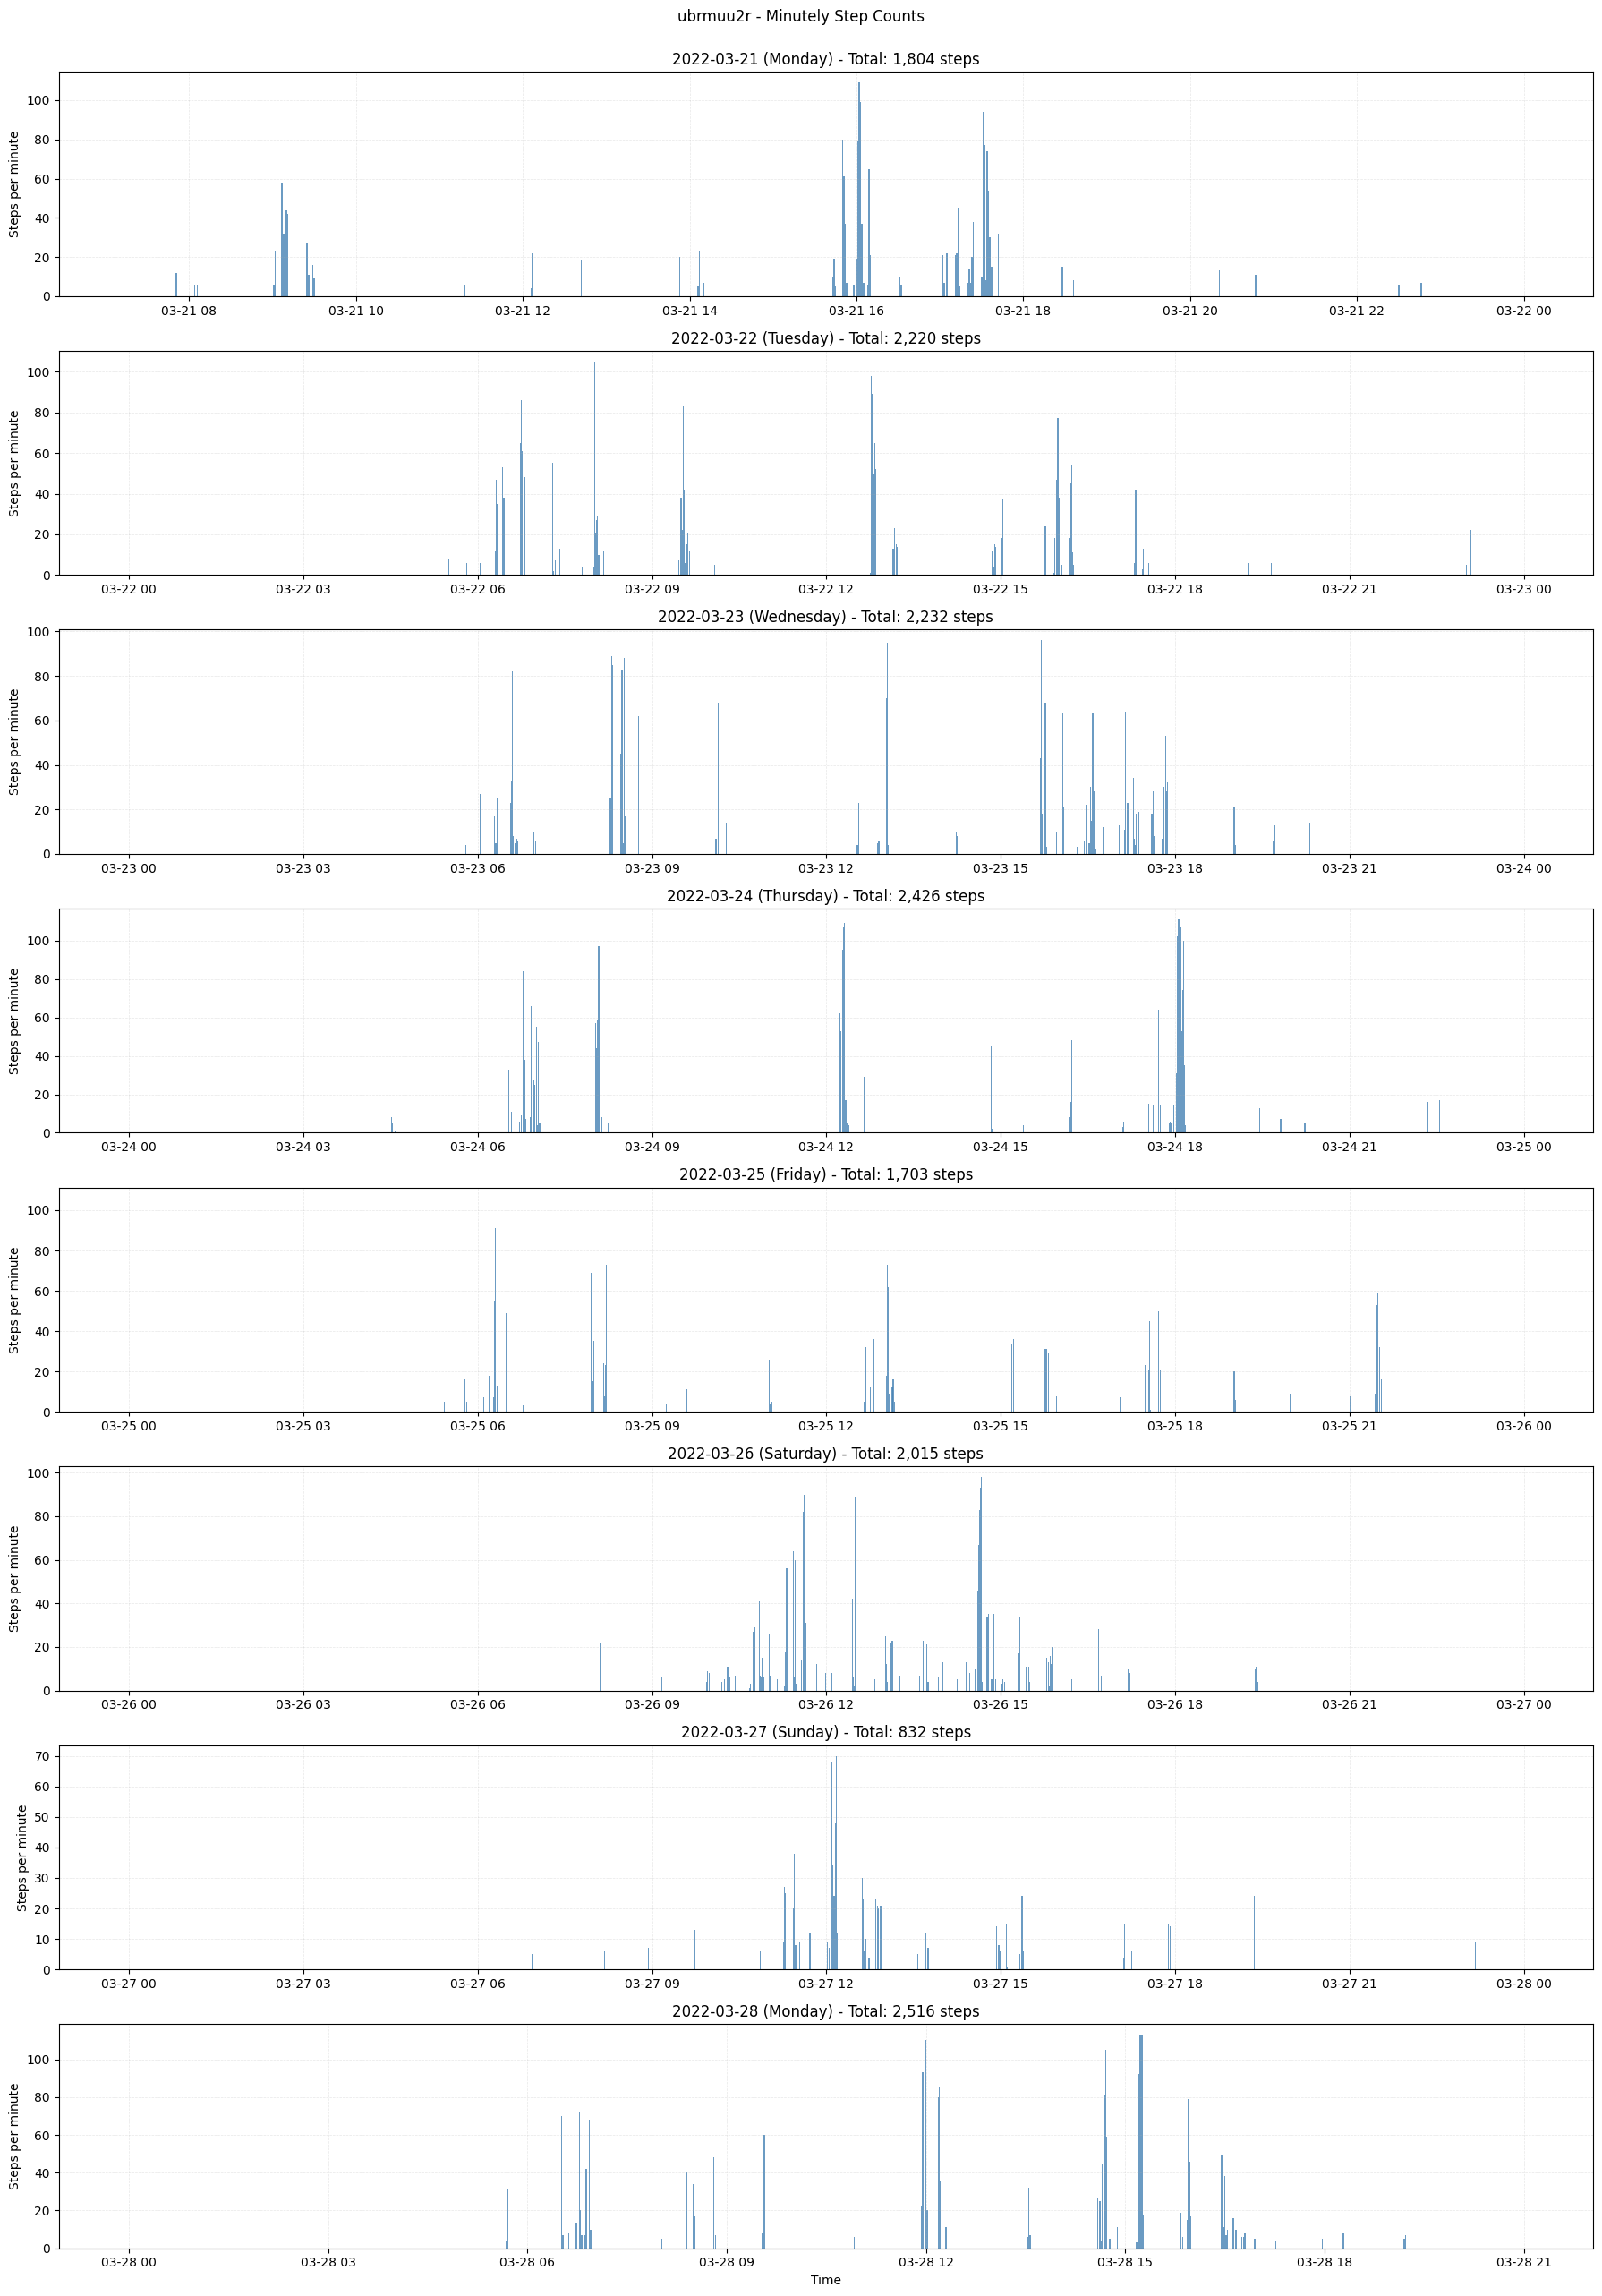


Plotting xwyd72l9...


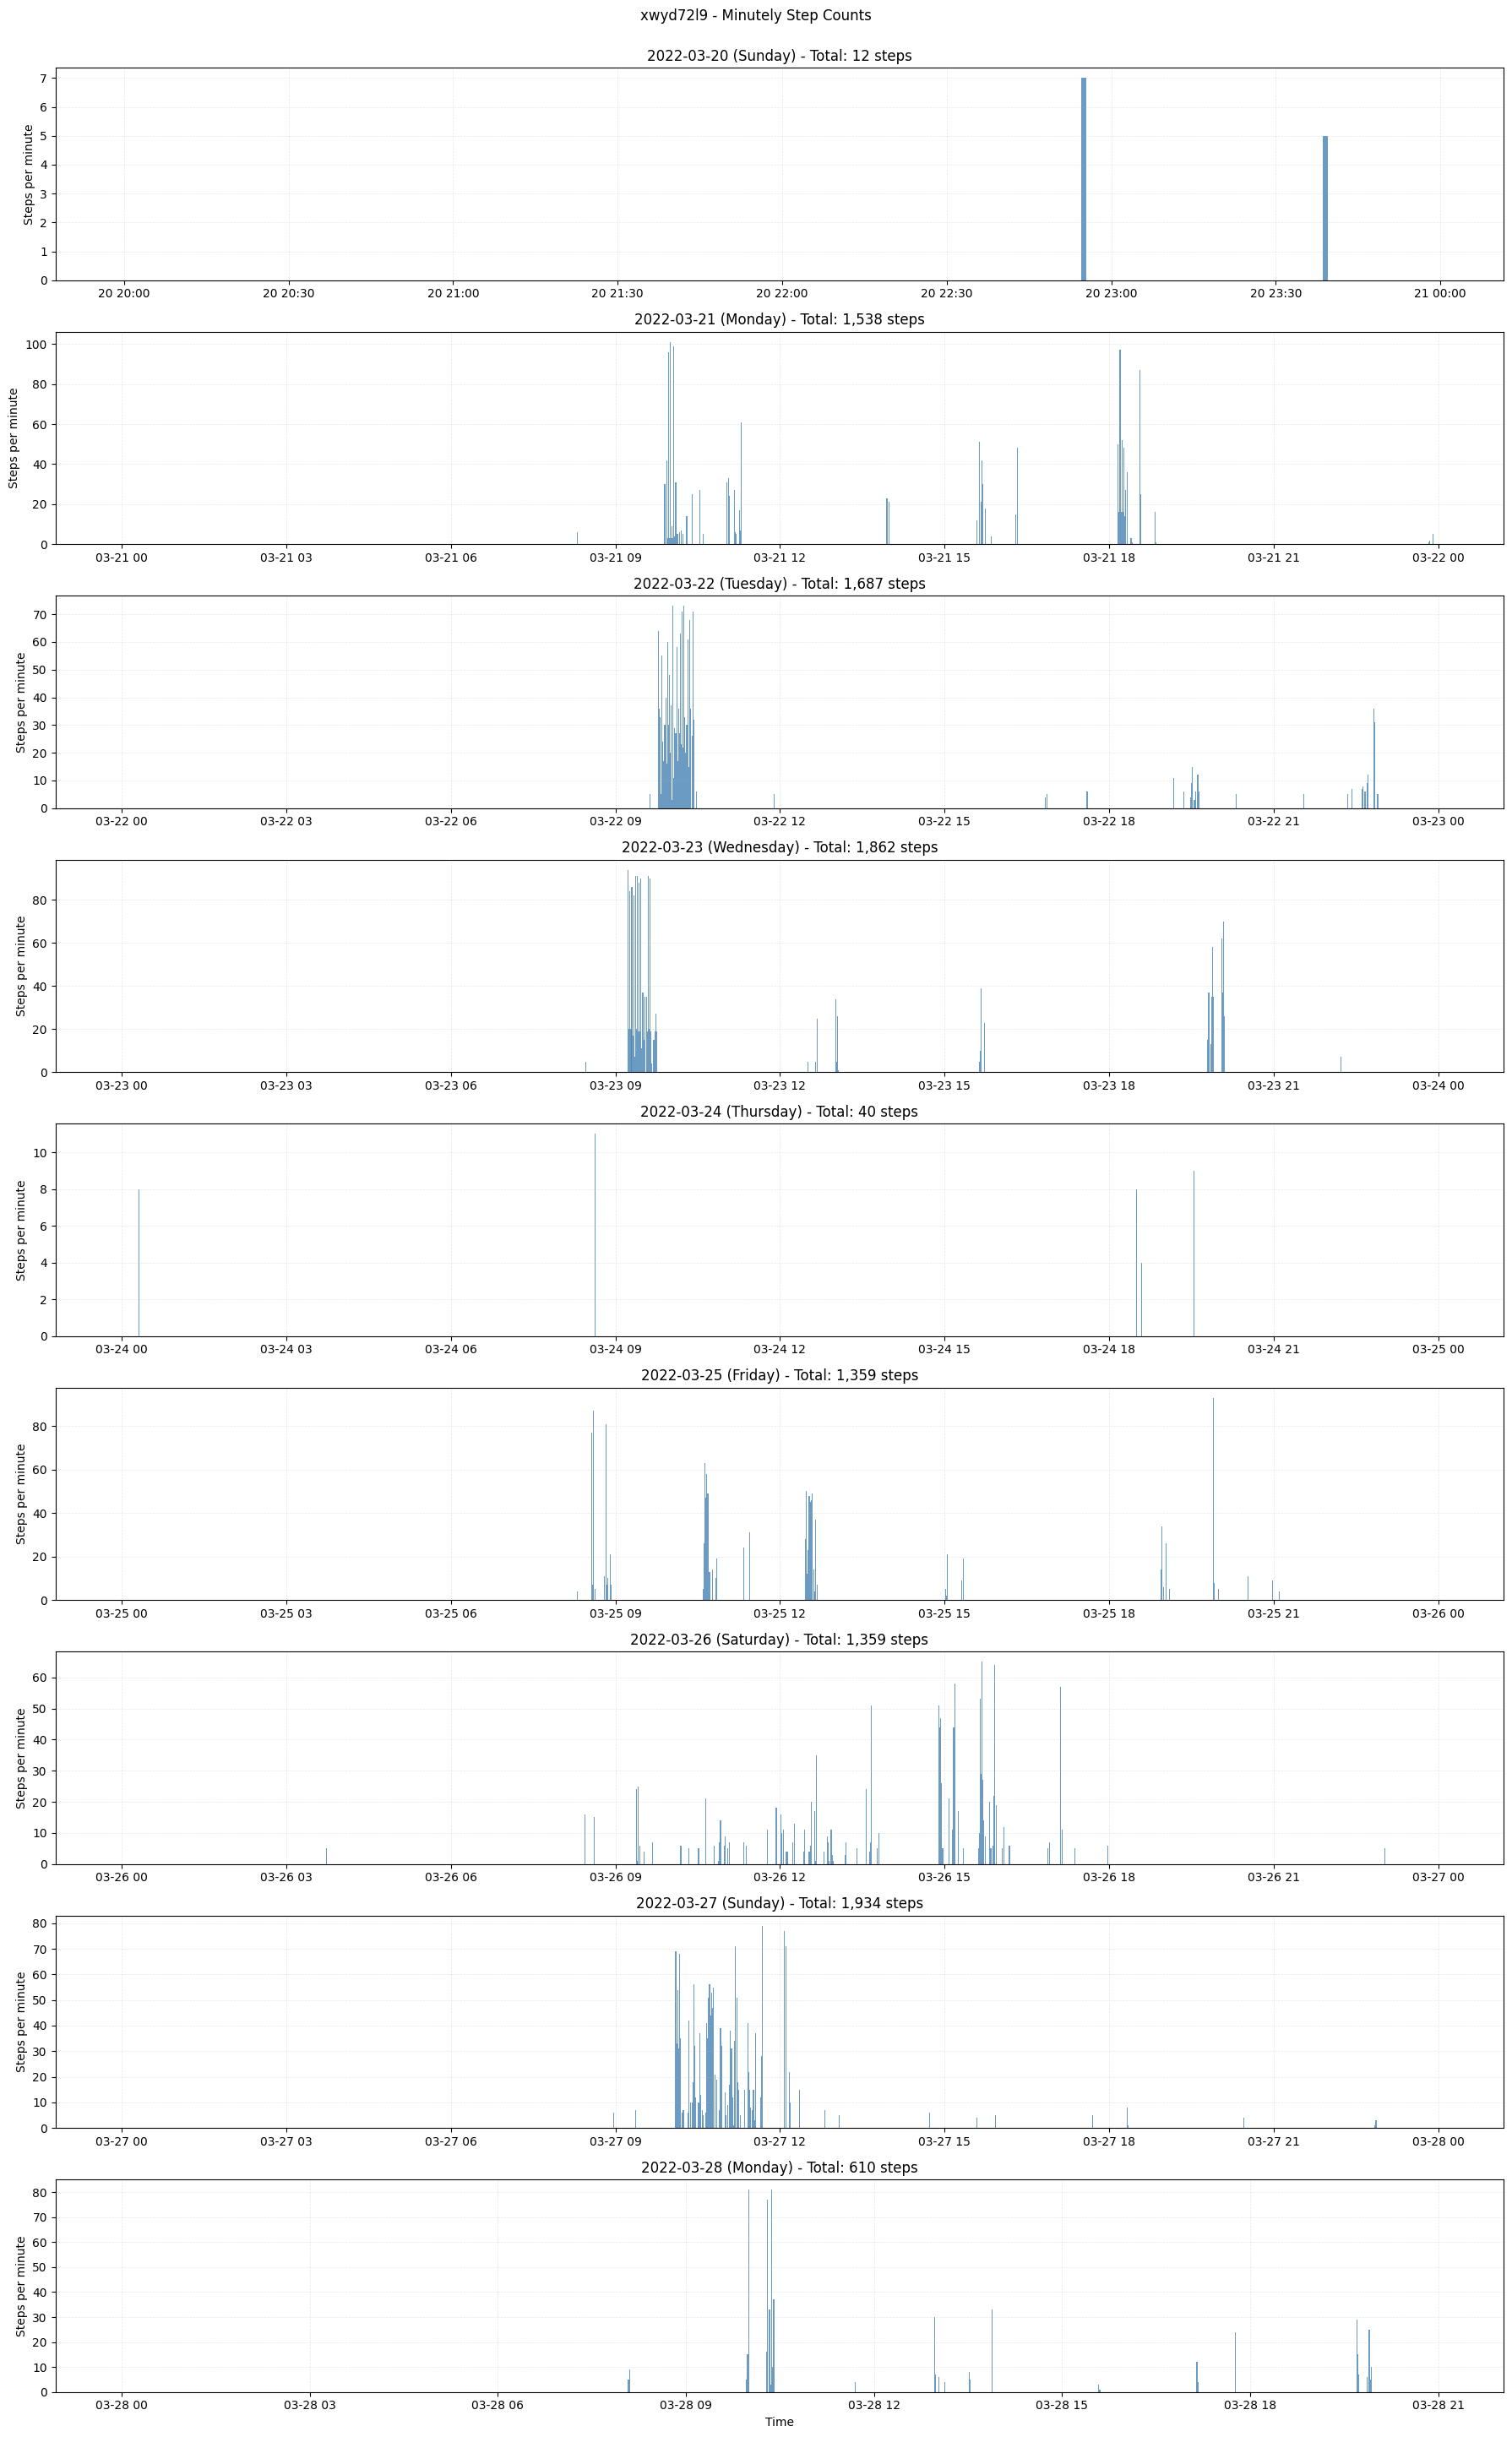


Plotting zg5uqa5l...


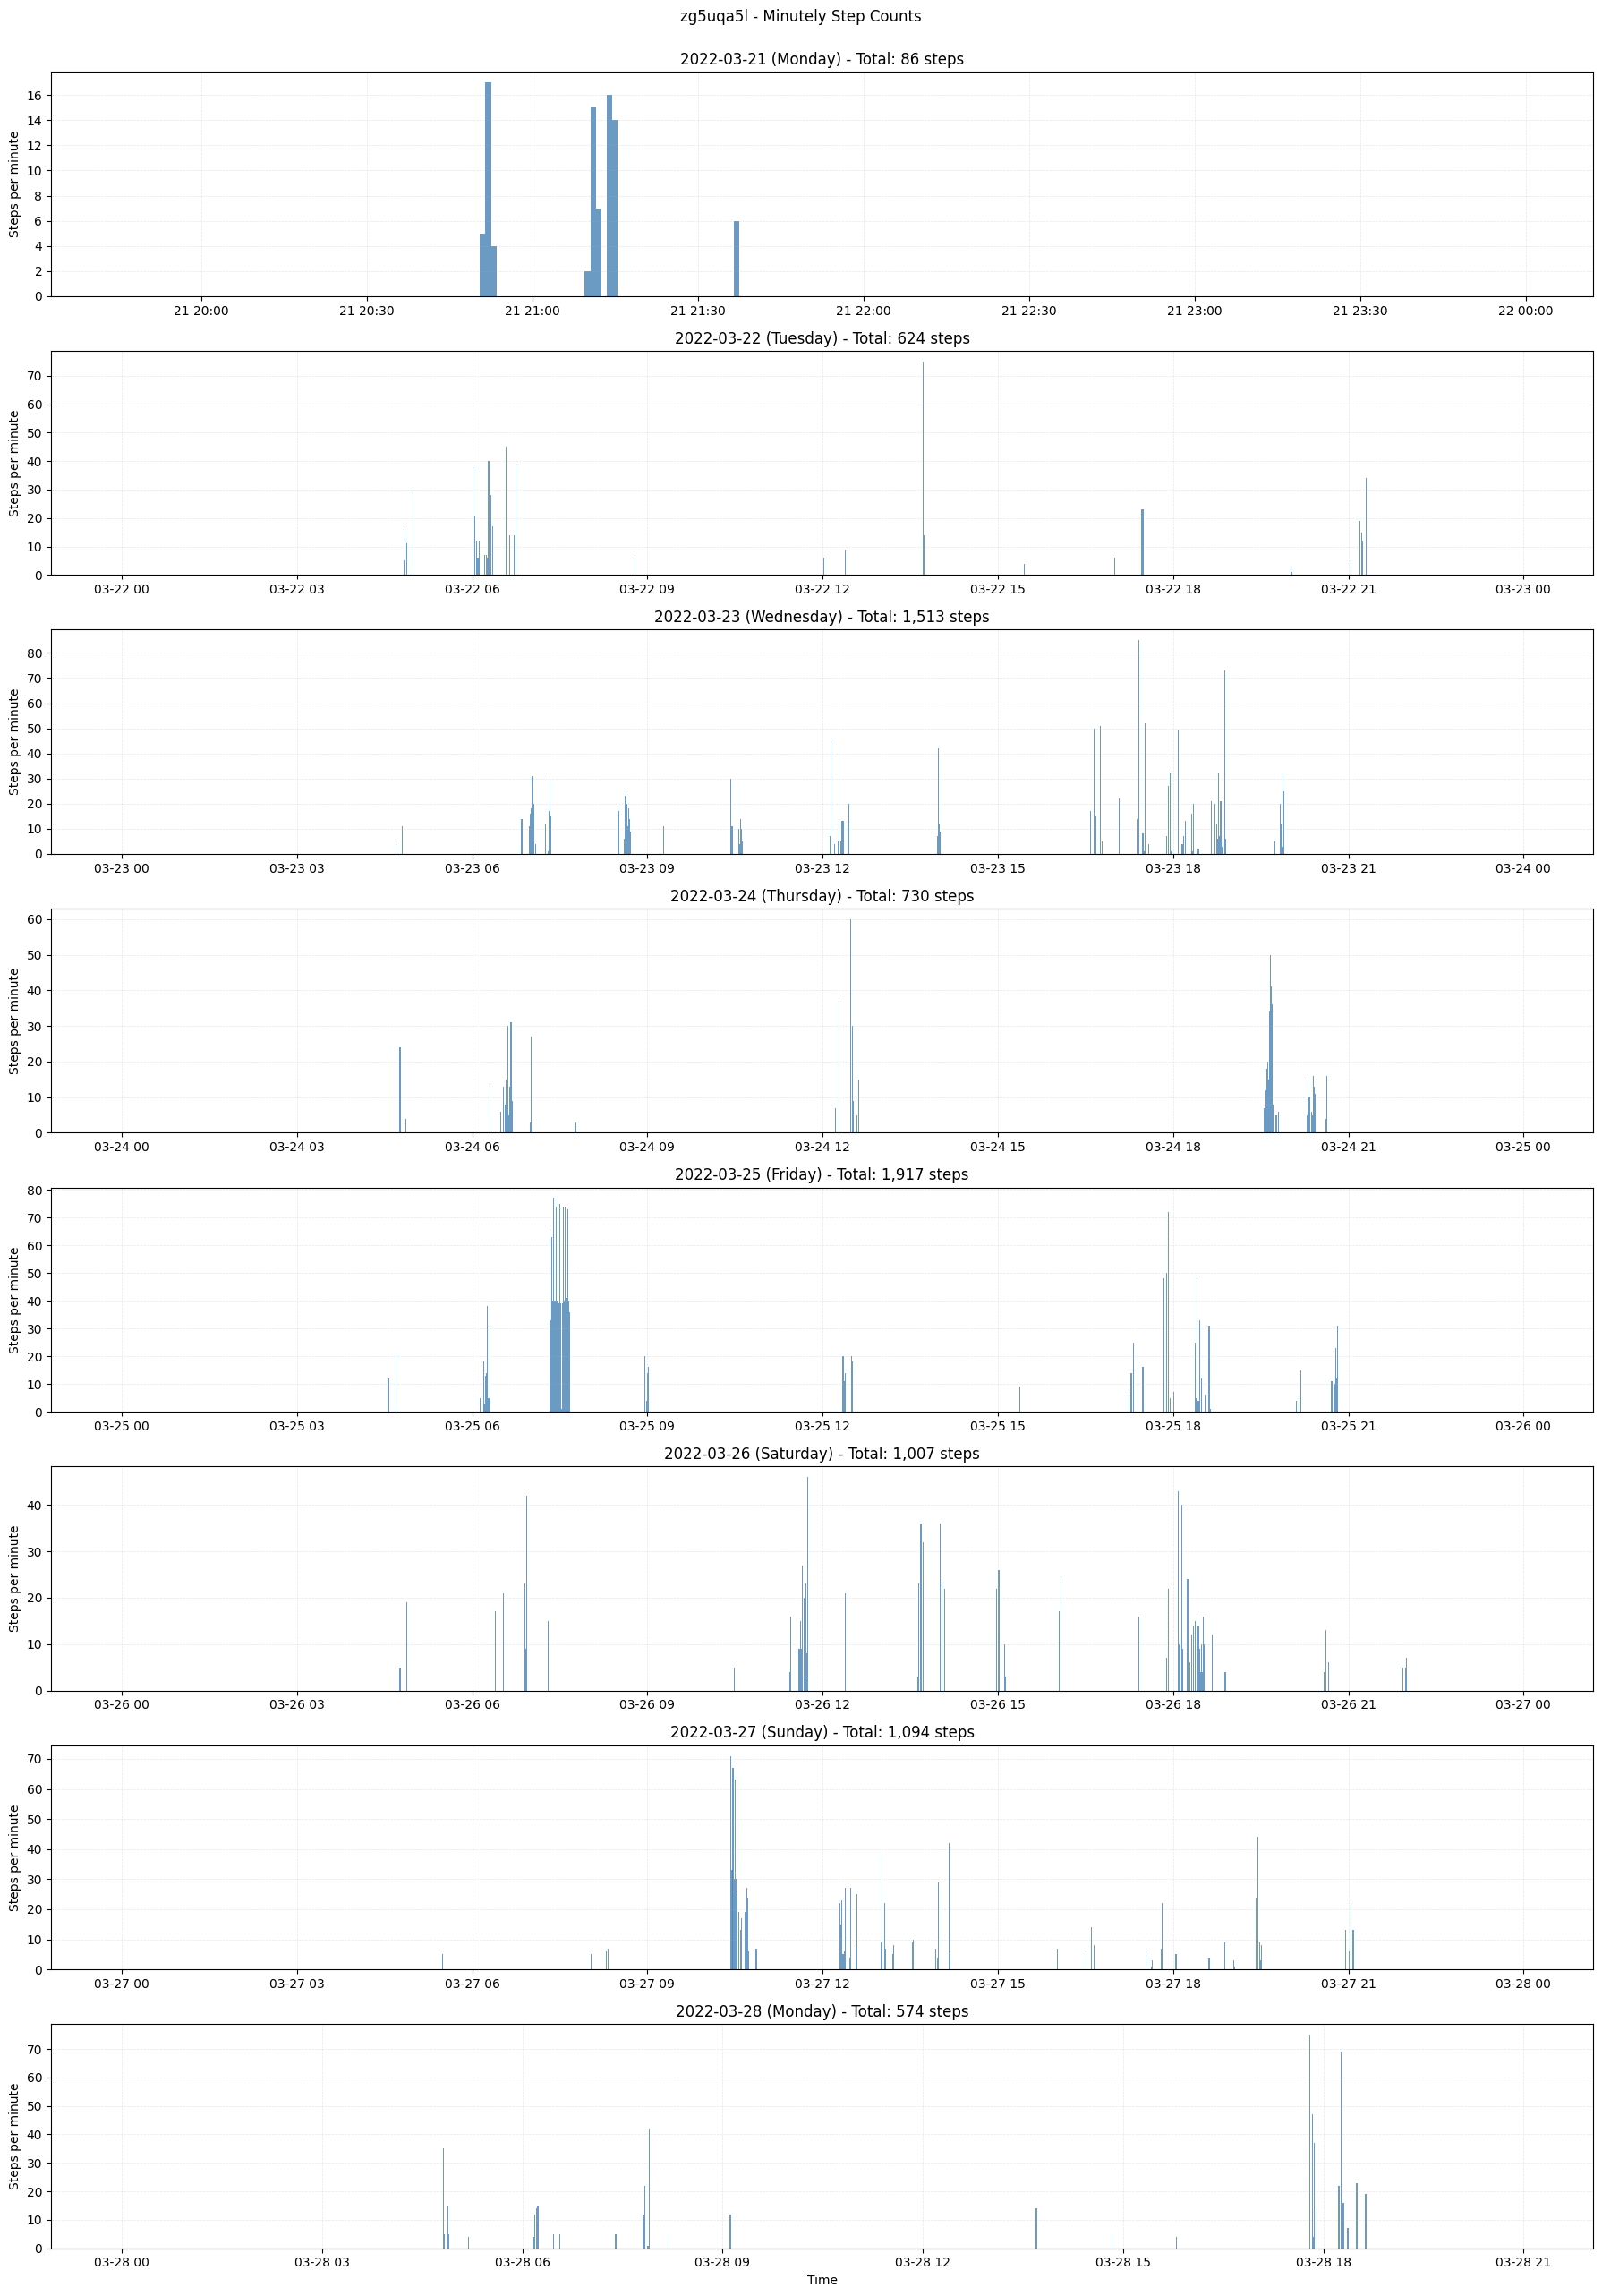

In [10]:
for subject_id, steps_df in subject_steps.items():
    print(f'\nPlotting {subject_id}...')
    
    # Add date column for grouping
    plot_df = steps_df.copy()
    plot_df['date'] = plot_df['timestamp'].dt.date
    unique_dates = sorted(plot_df['date'].unique())
    num_days = len(unique_dates)
    
    if num_days == 0:
        print('  No dates to plot.')
        continue
    
    fig, axes = plt.subplots(num_days, 1, figsize=(18, 3.2 * num_days), sharex=False)
    if num_days == 1:
        axes = [axes]
    
    for ax, day in zip(axes, unique_dates):
        day_df = plot_df[plot_df['date'] == day]
        times = day_df['timestamp']
        
        # Plot steps as bar chart
        ax.bar(times, day_df['steps'], width=0.0007, color='steelblue', alpha=0.8)
        
        weekday = pd.Timestamp(day).strftime('%A')
        daily_total = day_df['steps'].sum()
        ax.set_title(f'{day} ({weekday}) - Total: {daily_total:,} steps')
        ax.set_ylabel('Steps per minute')
        ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)
    axes[-1].set_xlabel('Time')
    fig.suptitle(f'{subject_id} - Minutely Step Counts', y=1.0)
    plt.tight_layout()
    plt.savefig(f'../plots/{subject_id}_minutely_steps.png', bbox_inches='tight', dpi=200)
    plt.show()


## Plot Walking Time Distribution


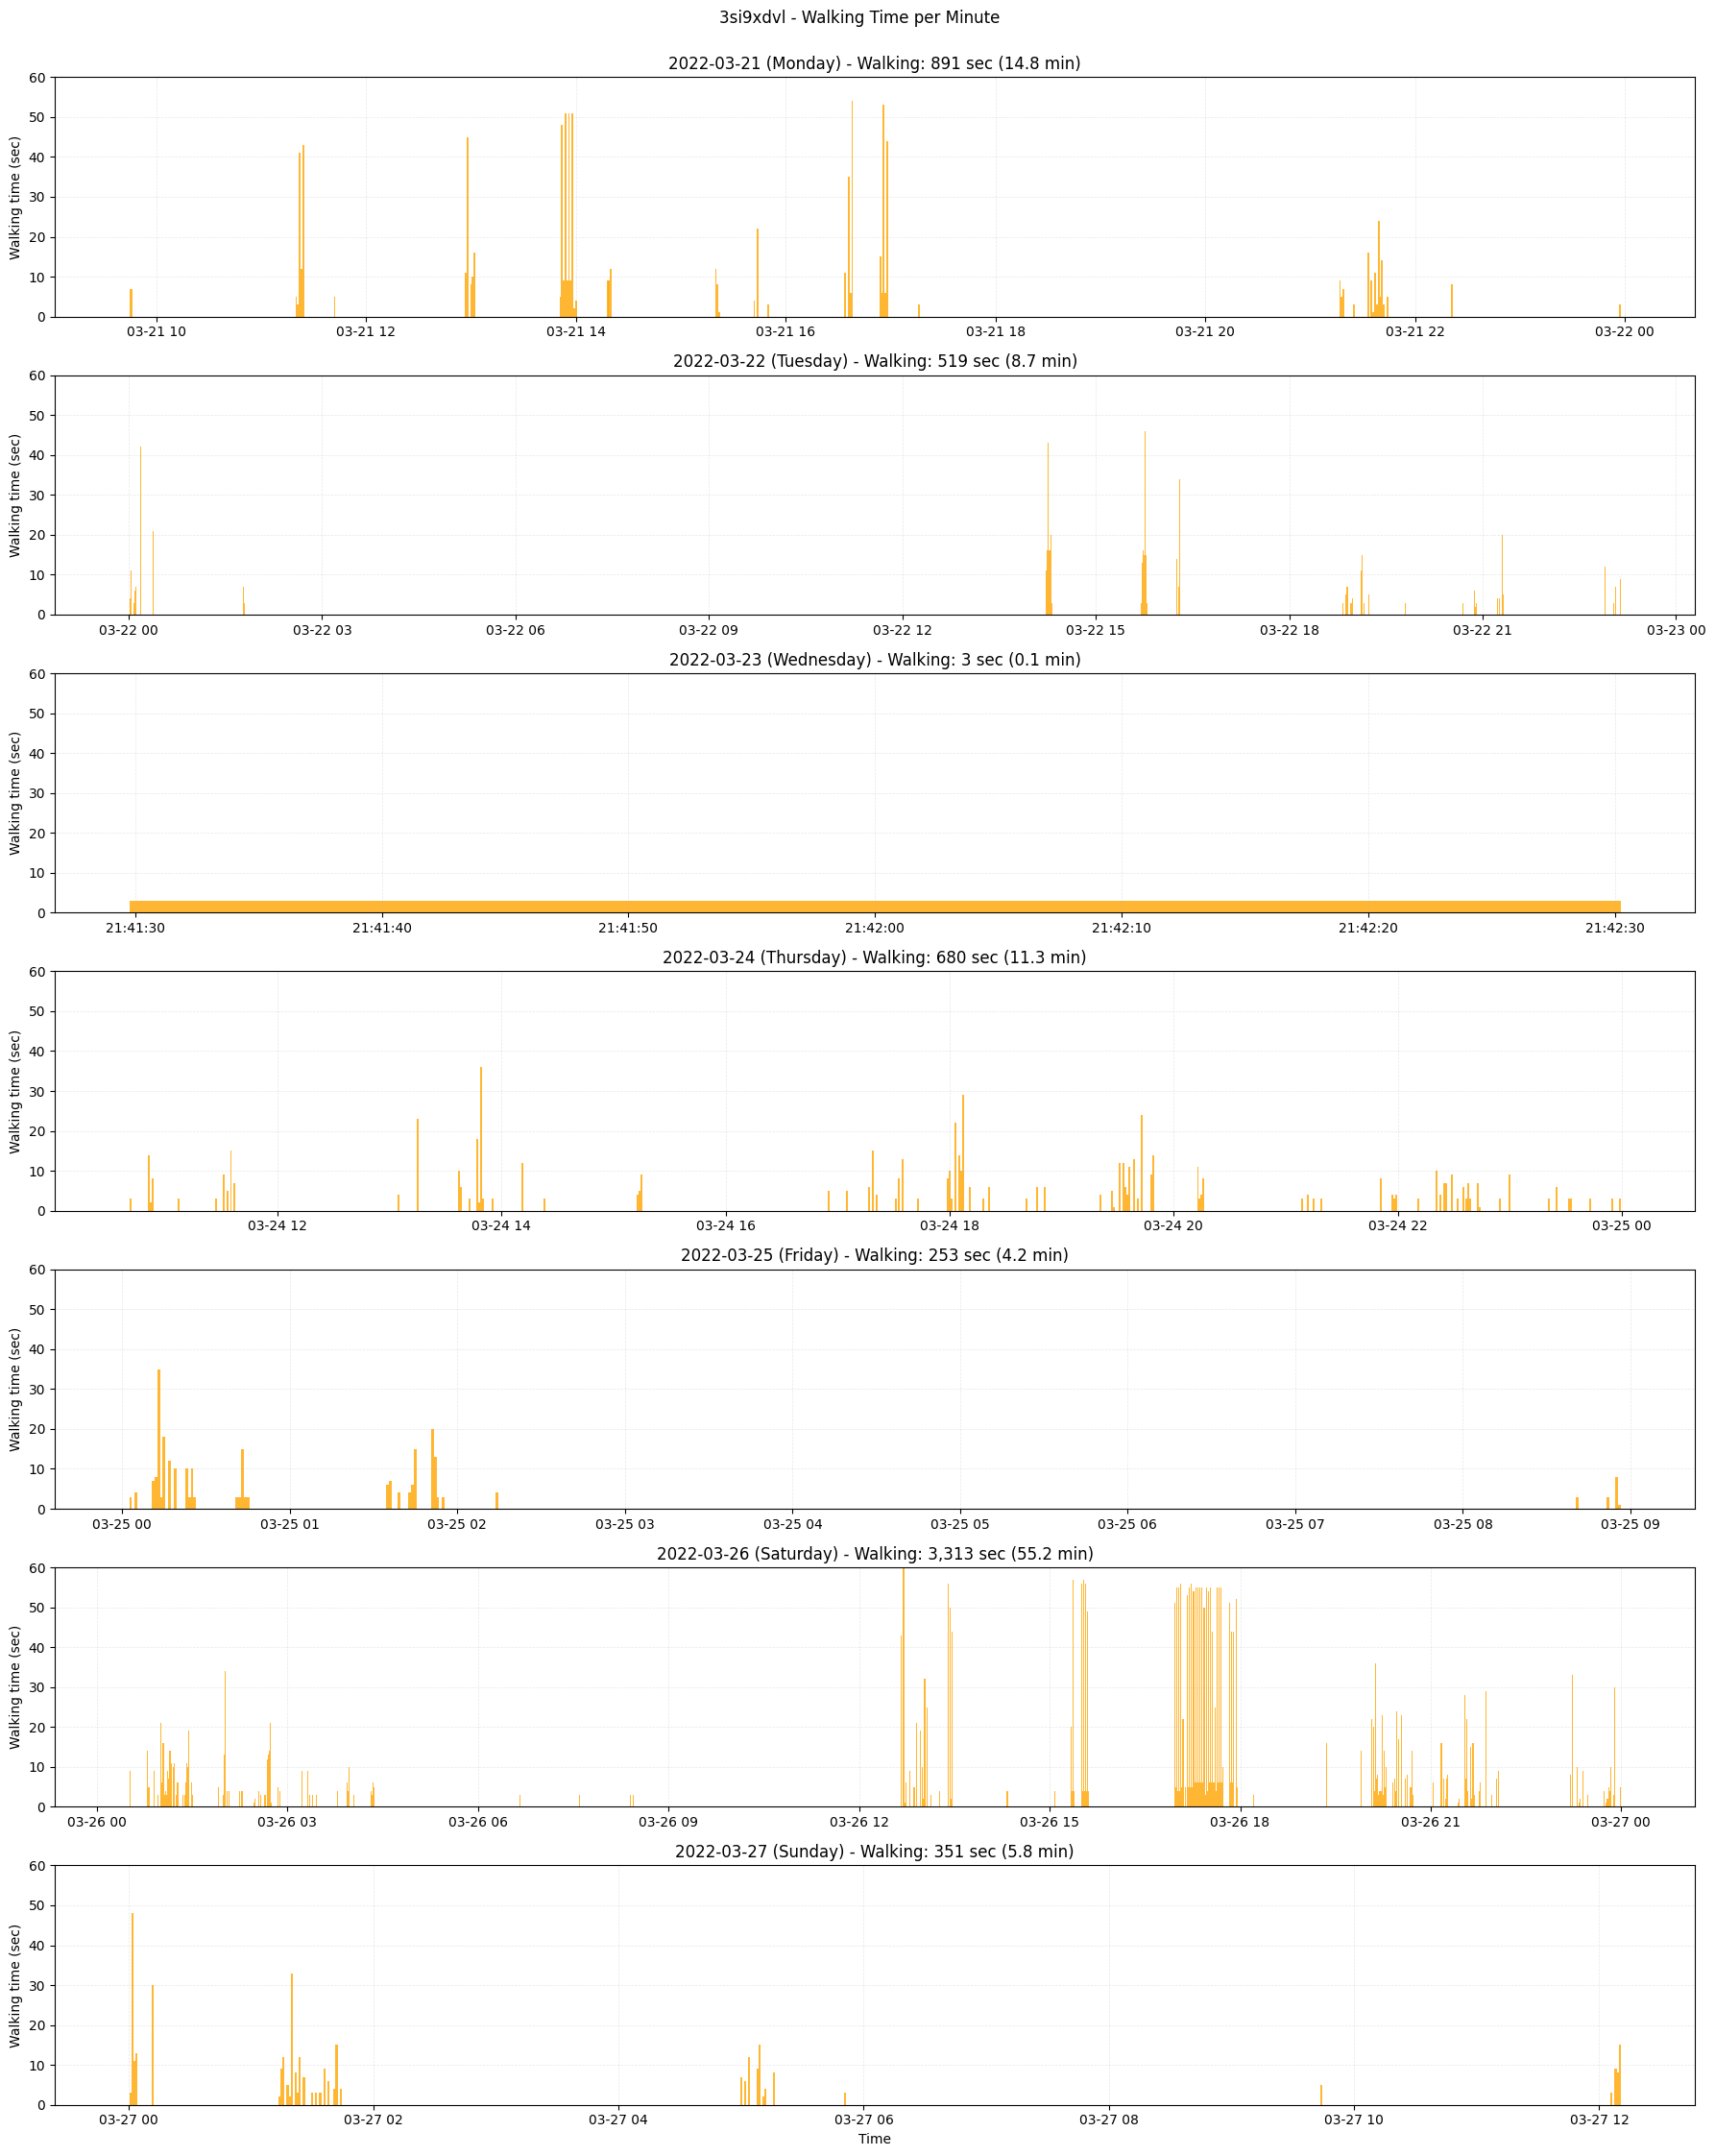

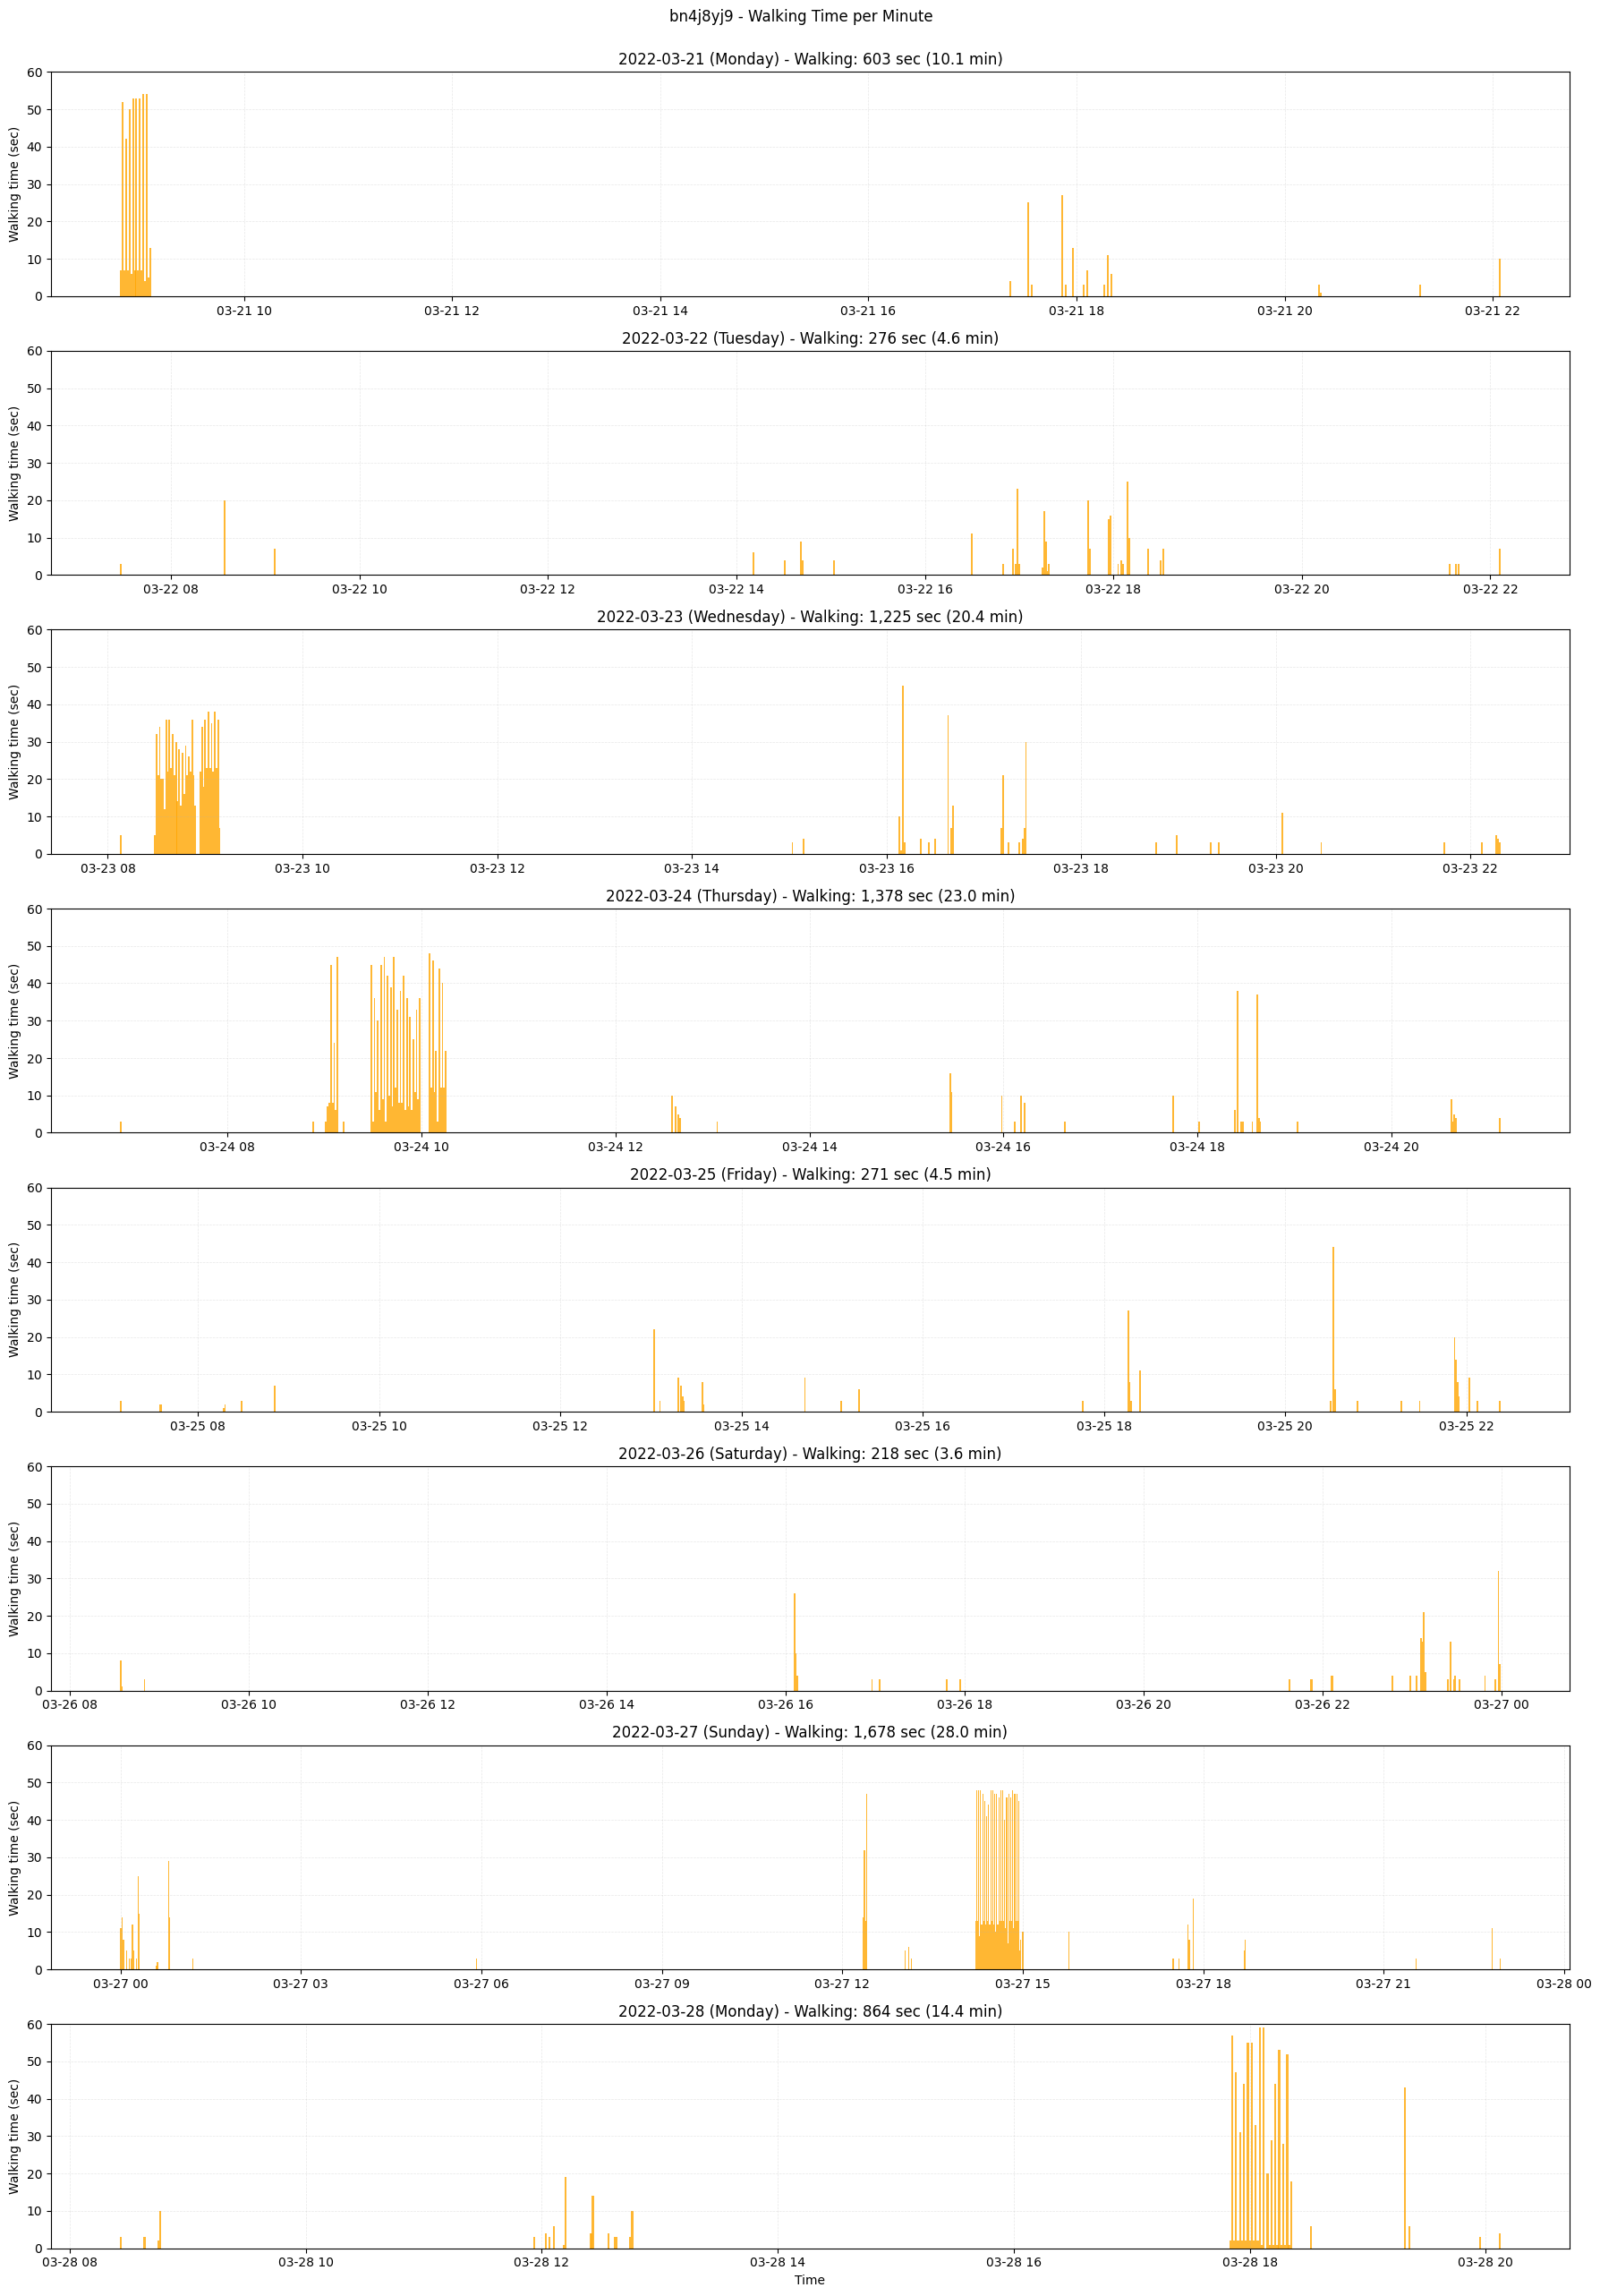

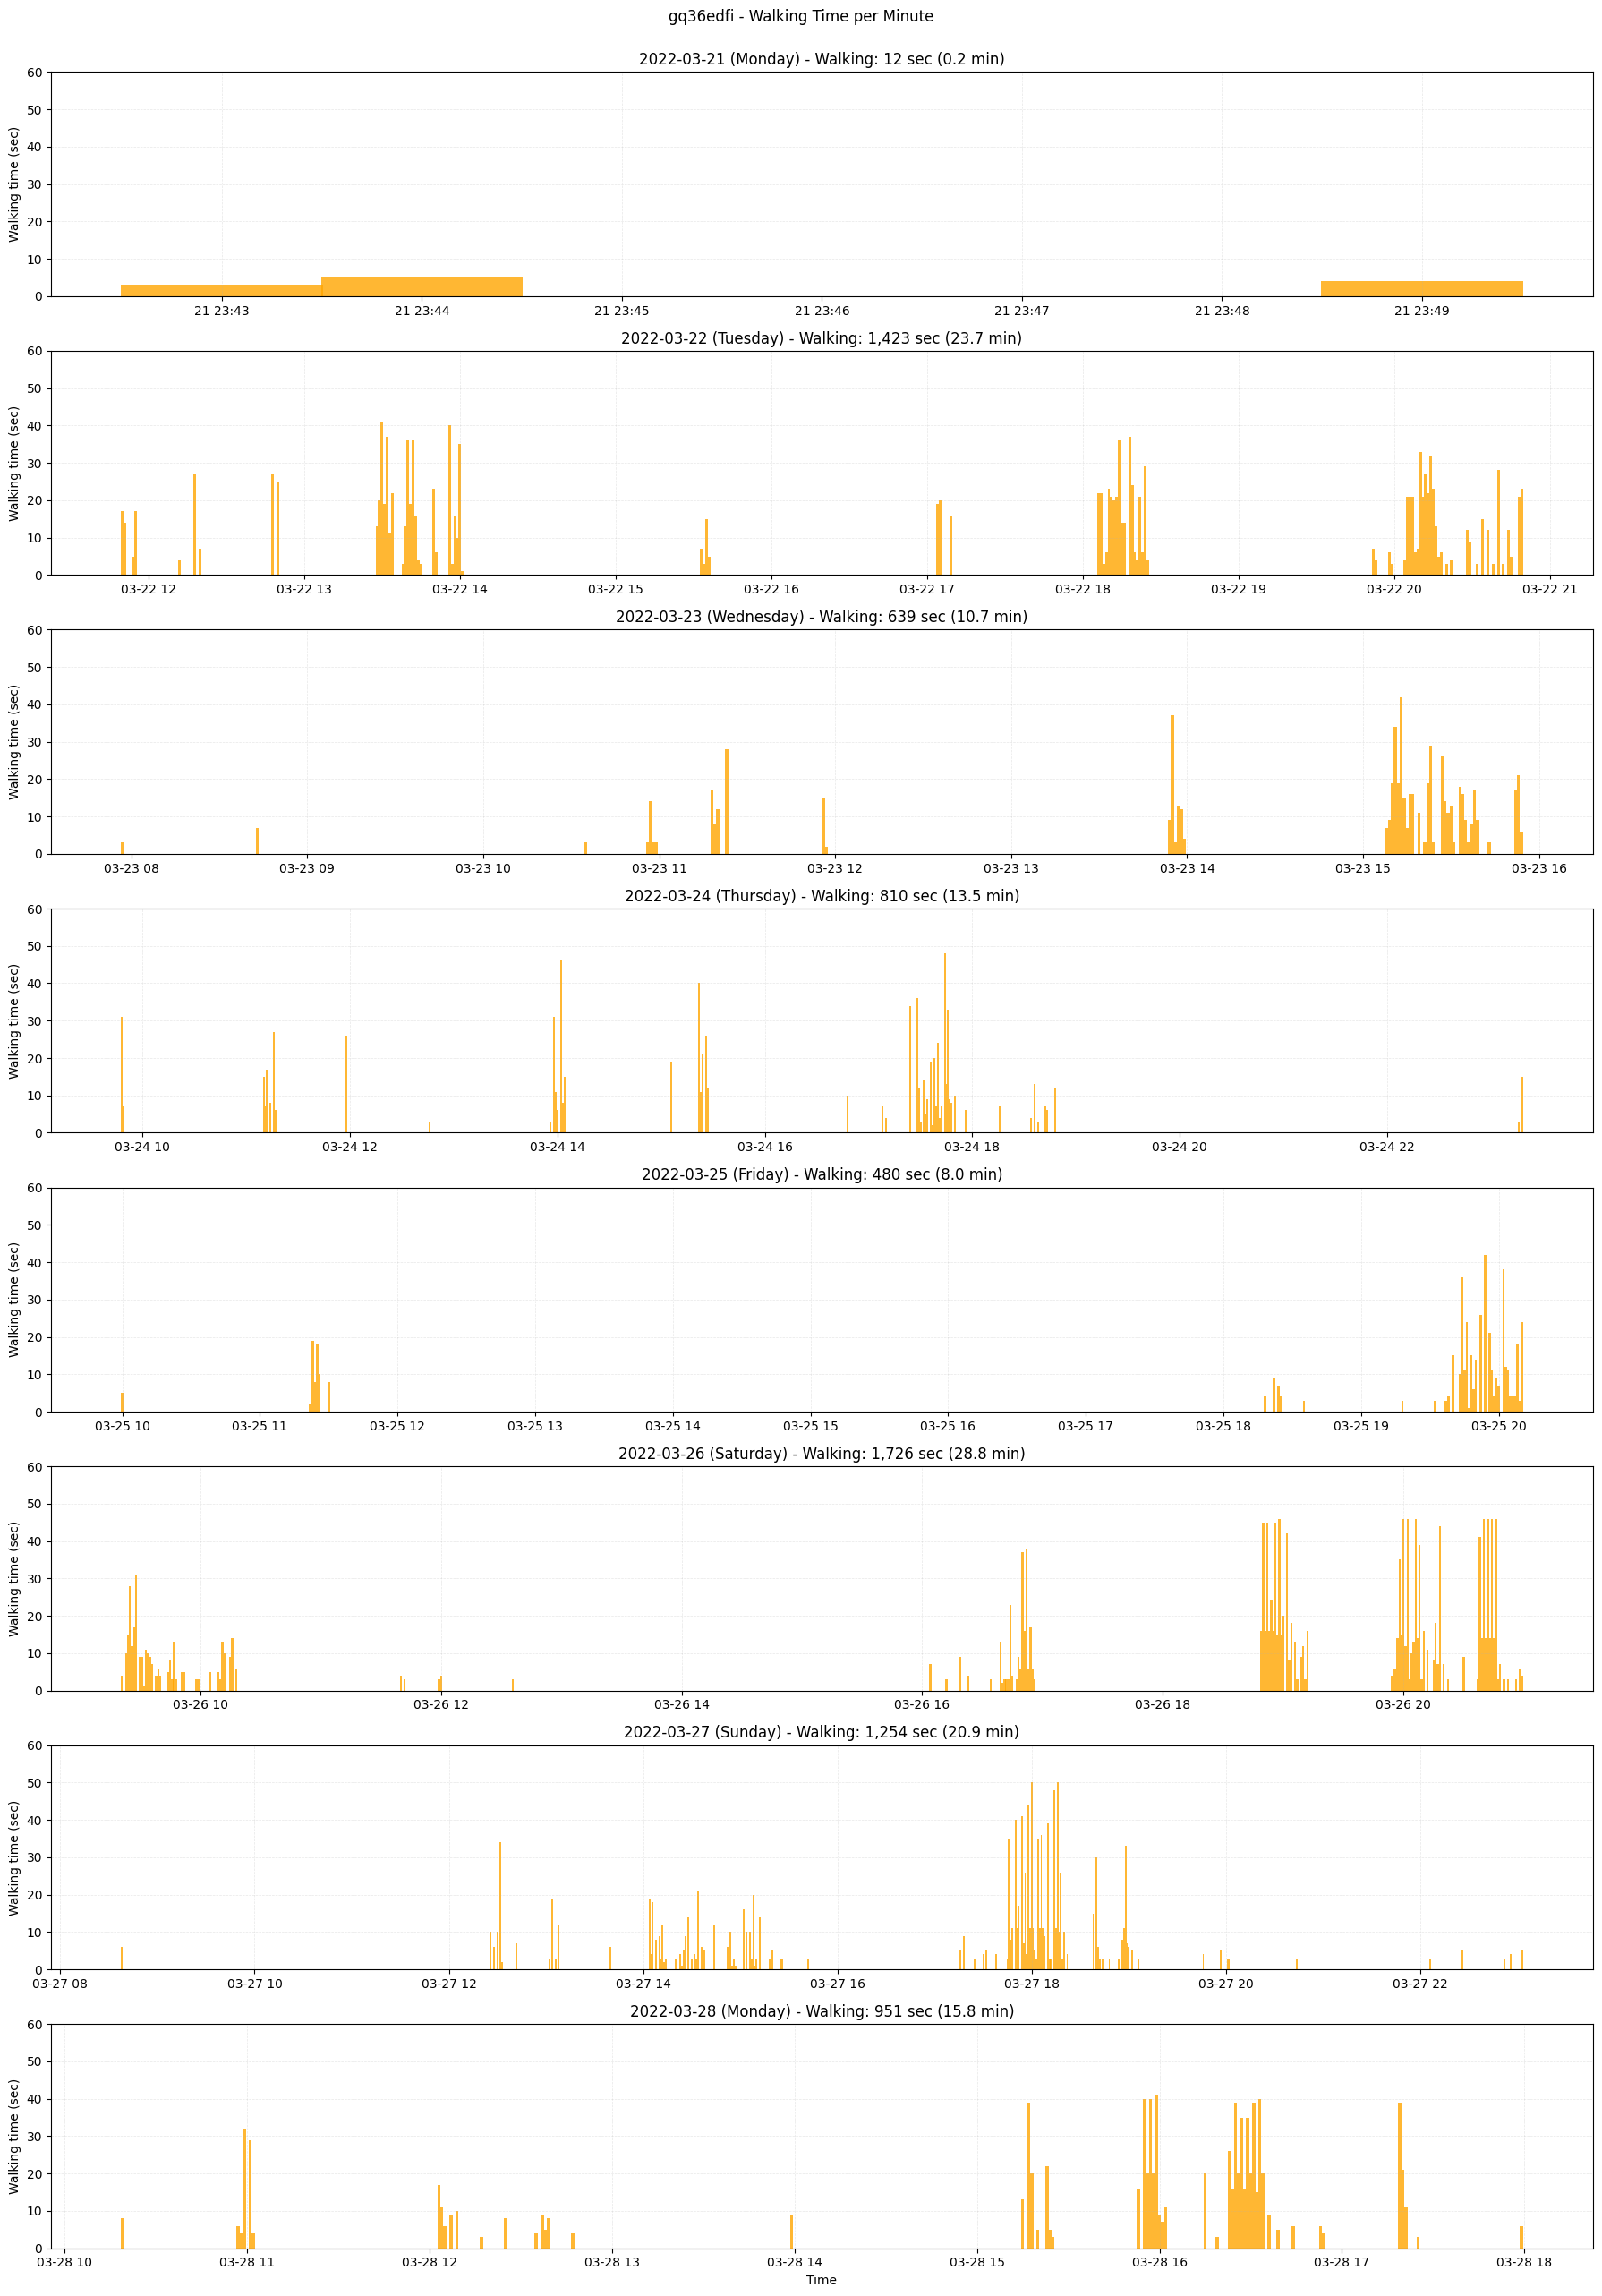

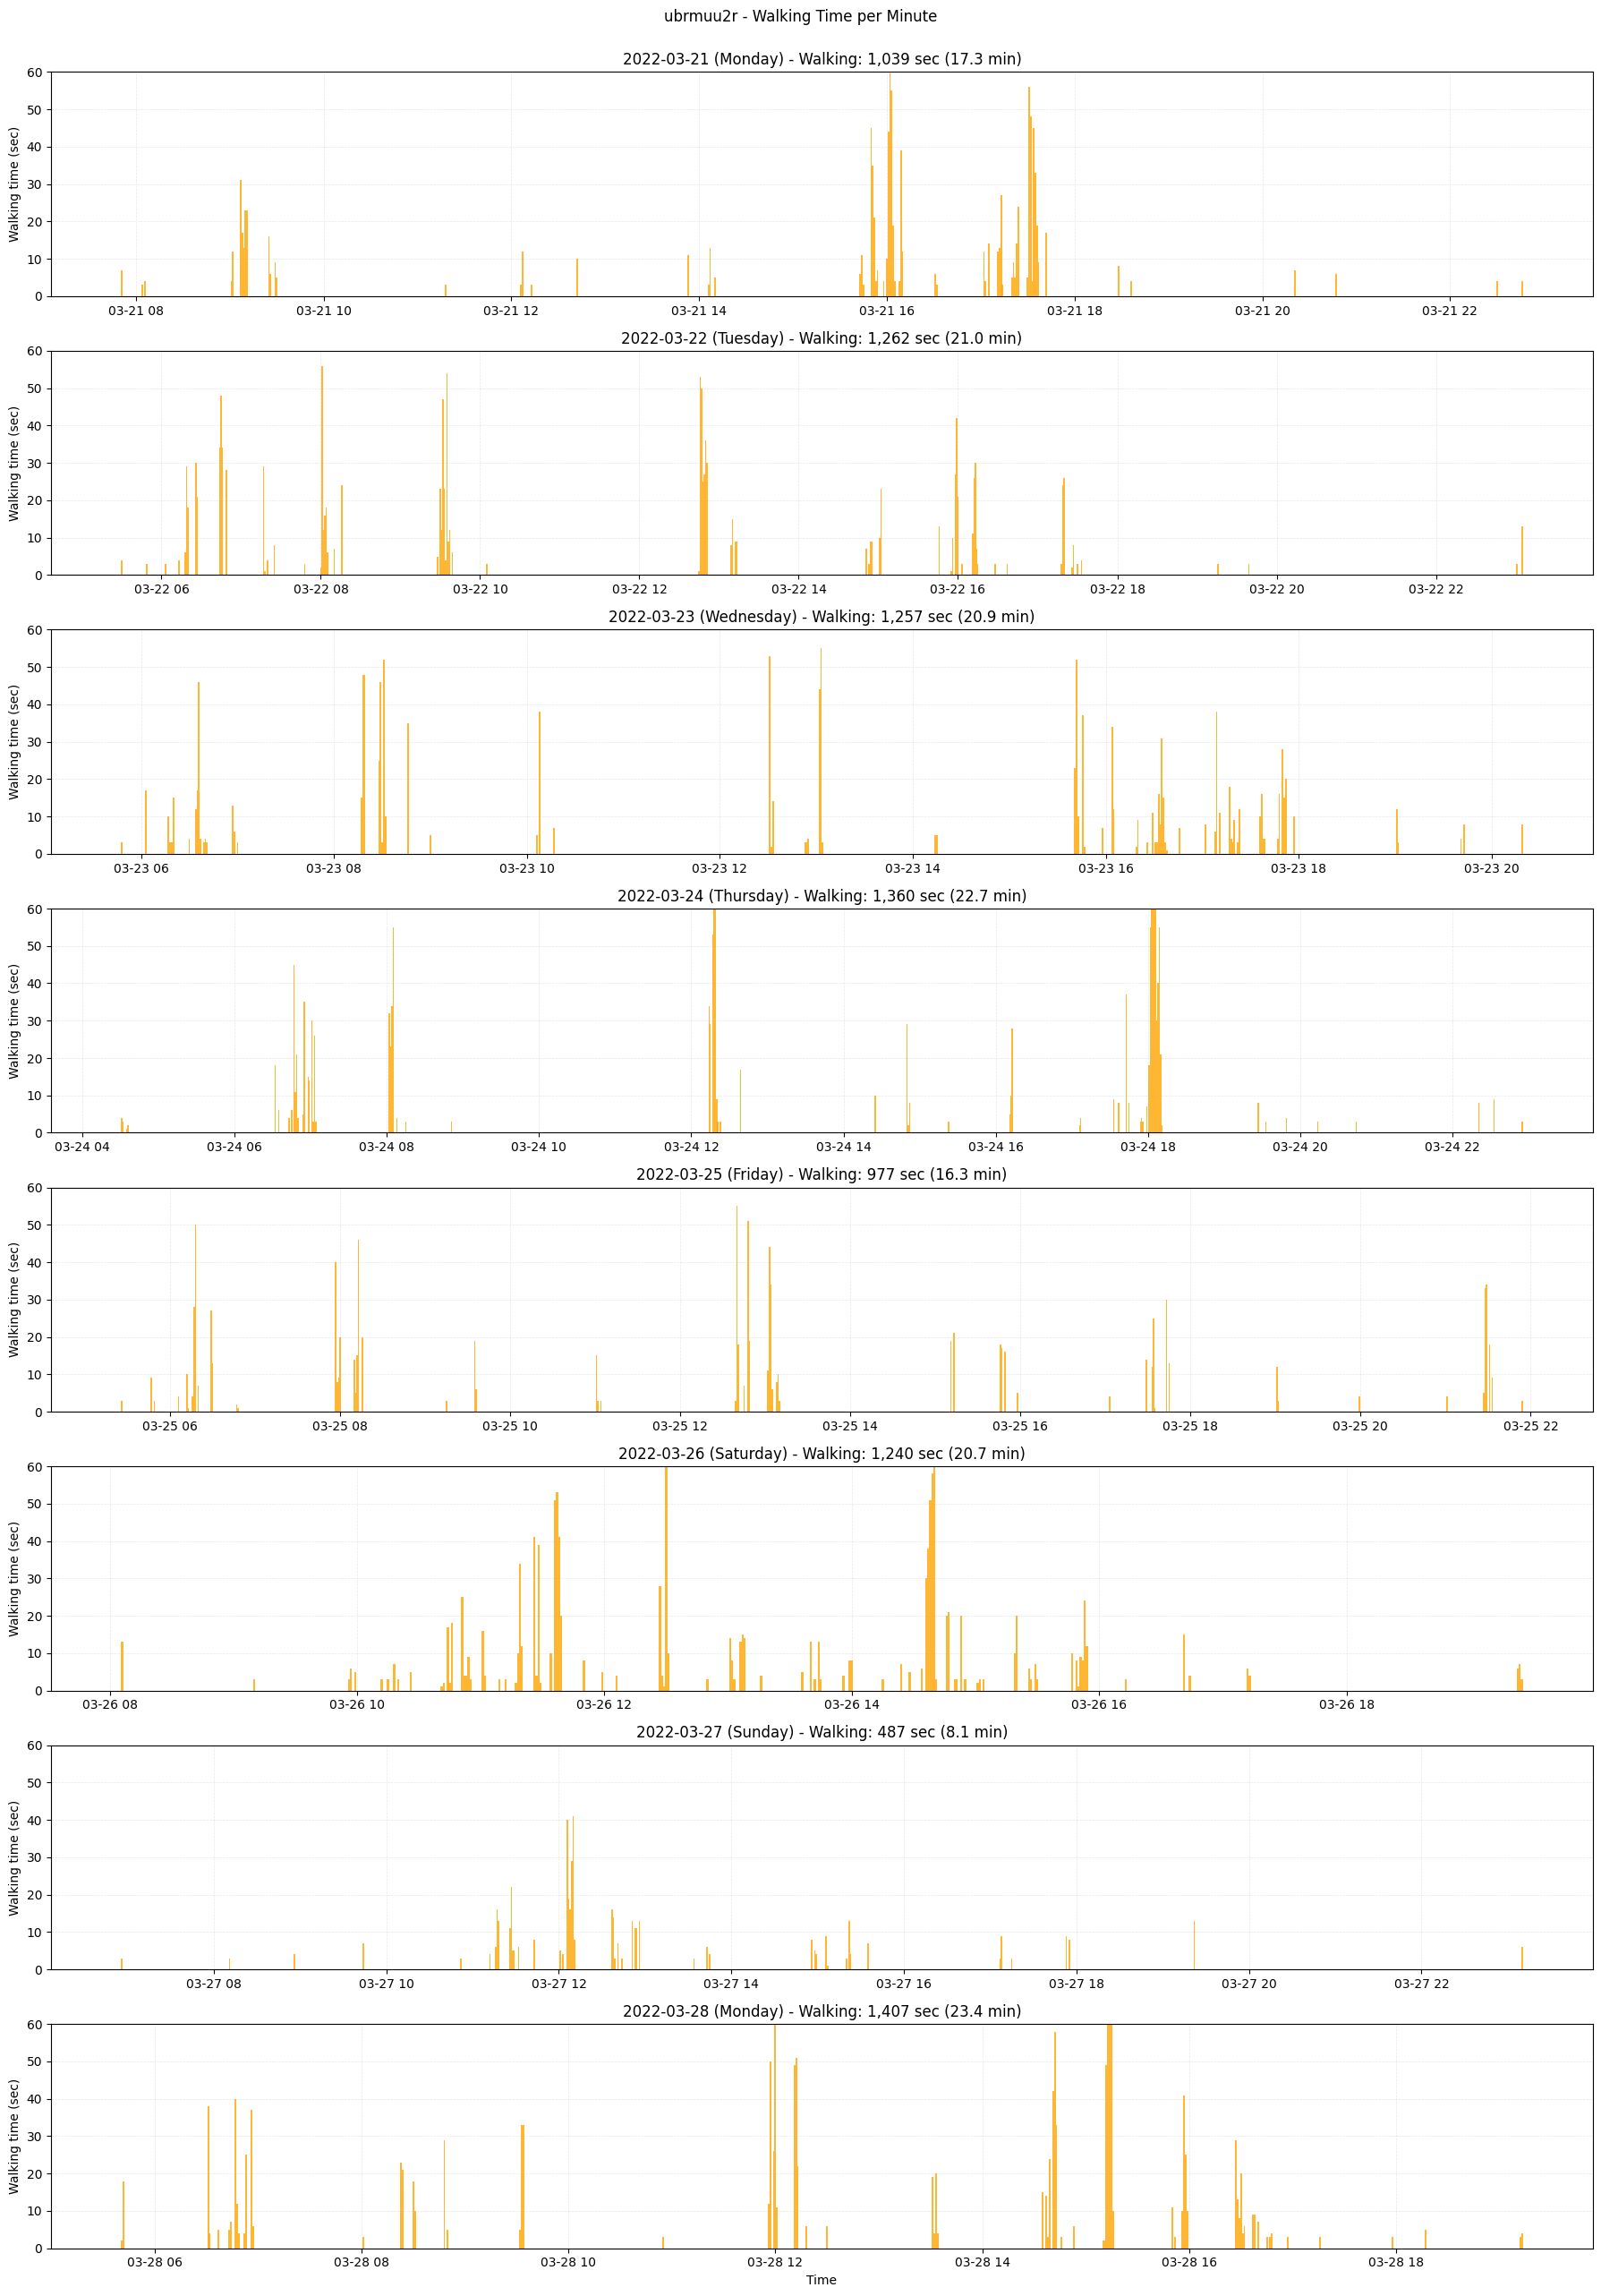

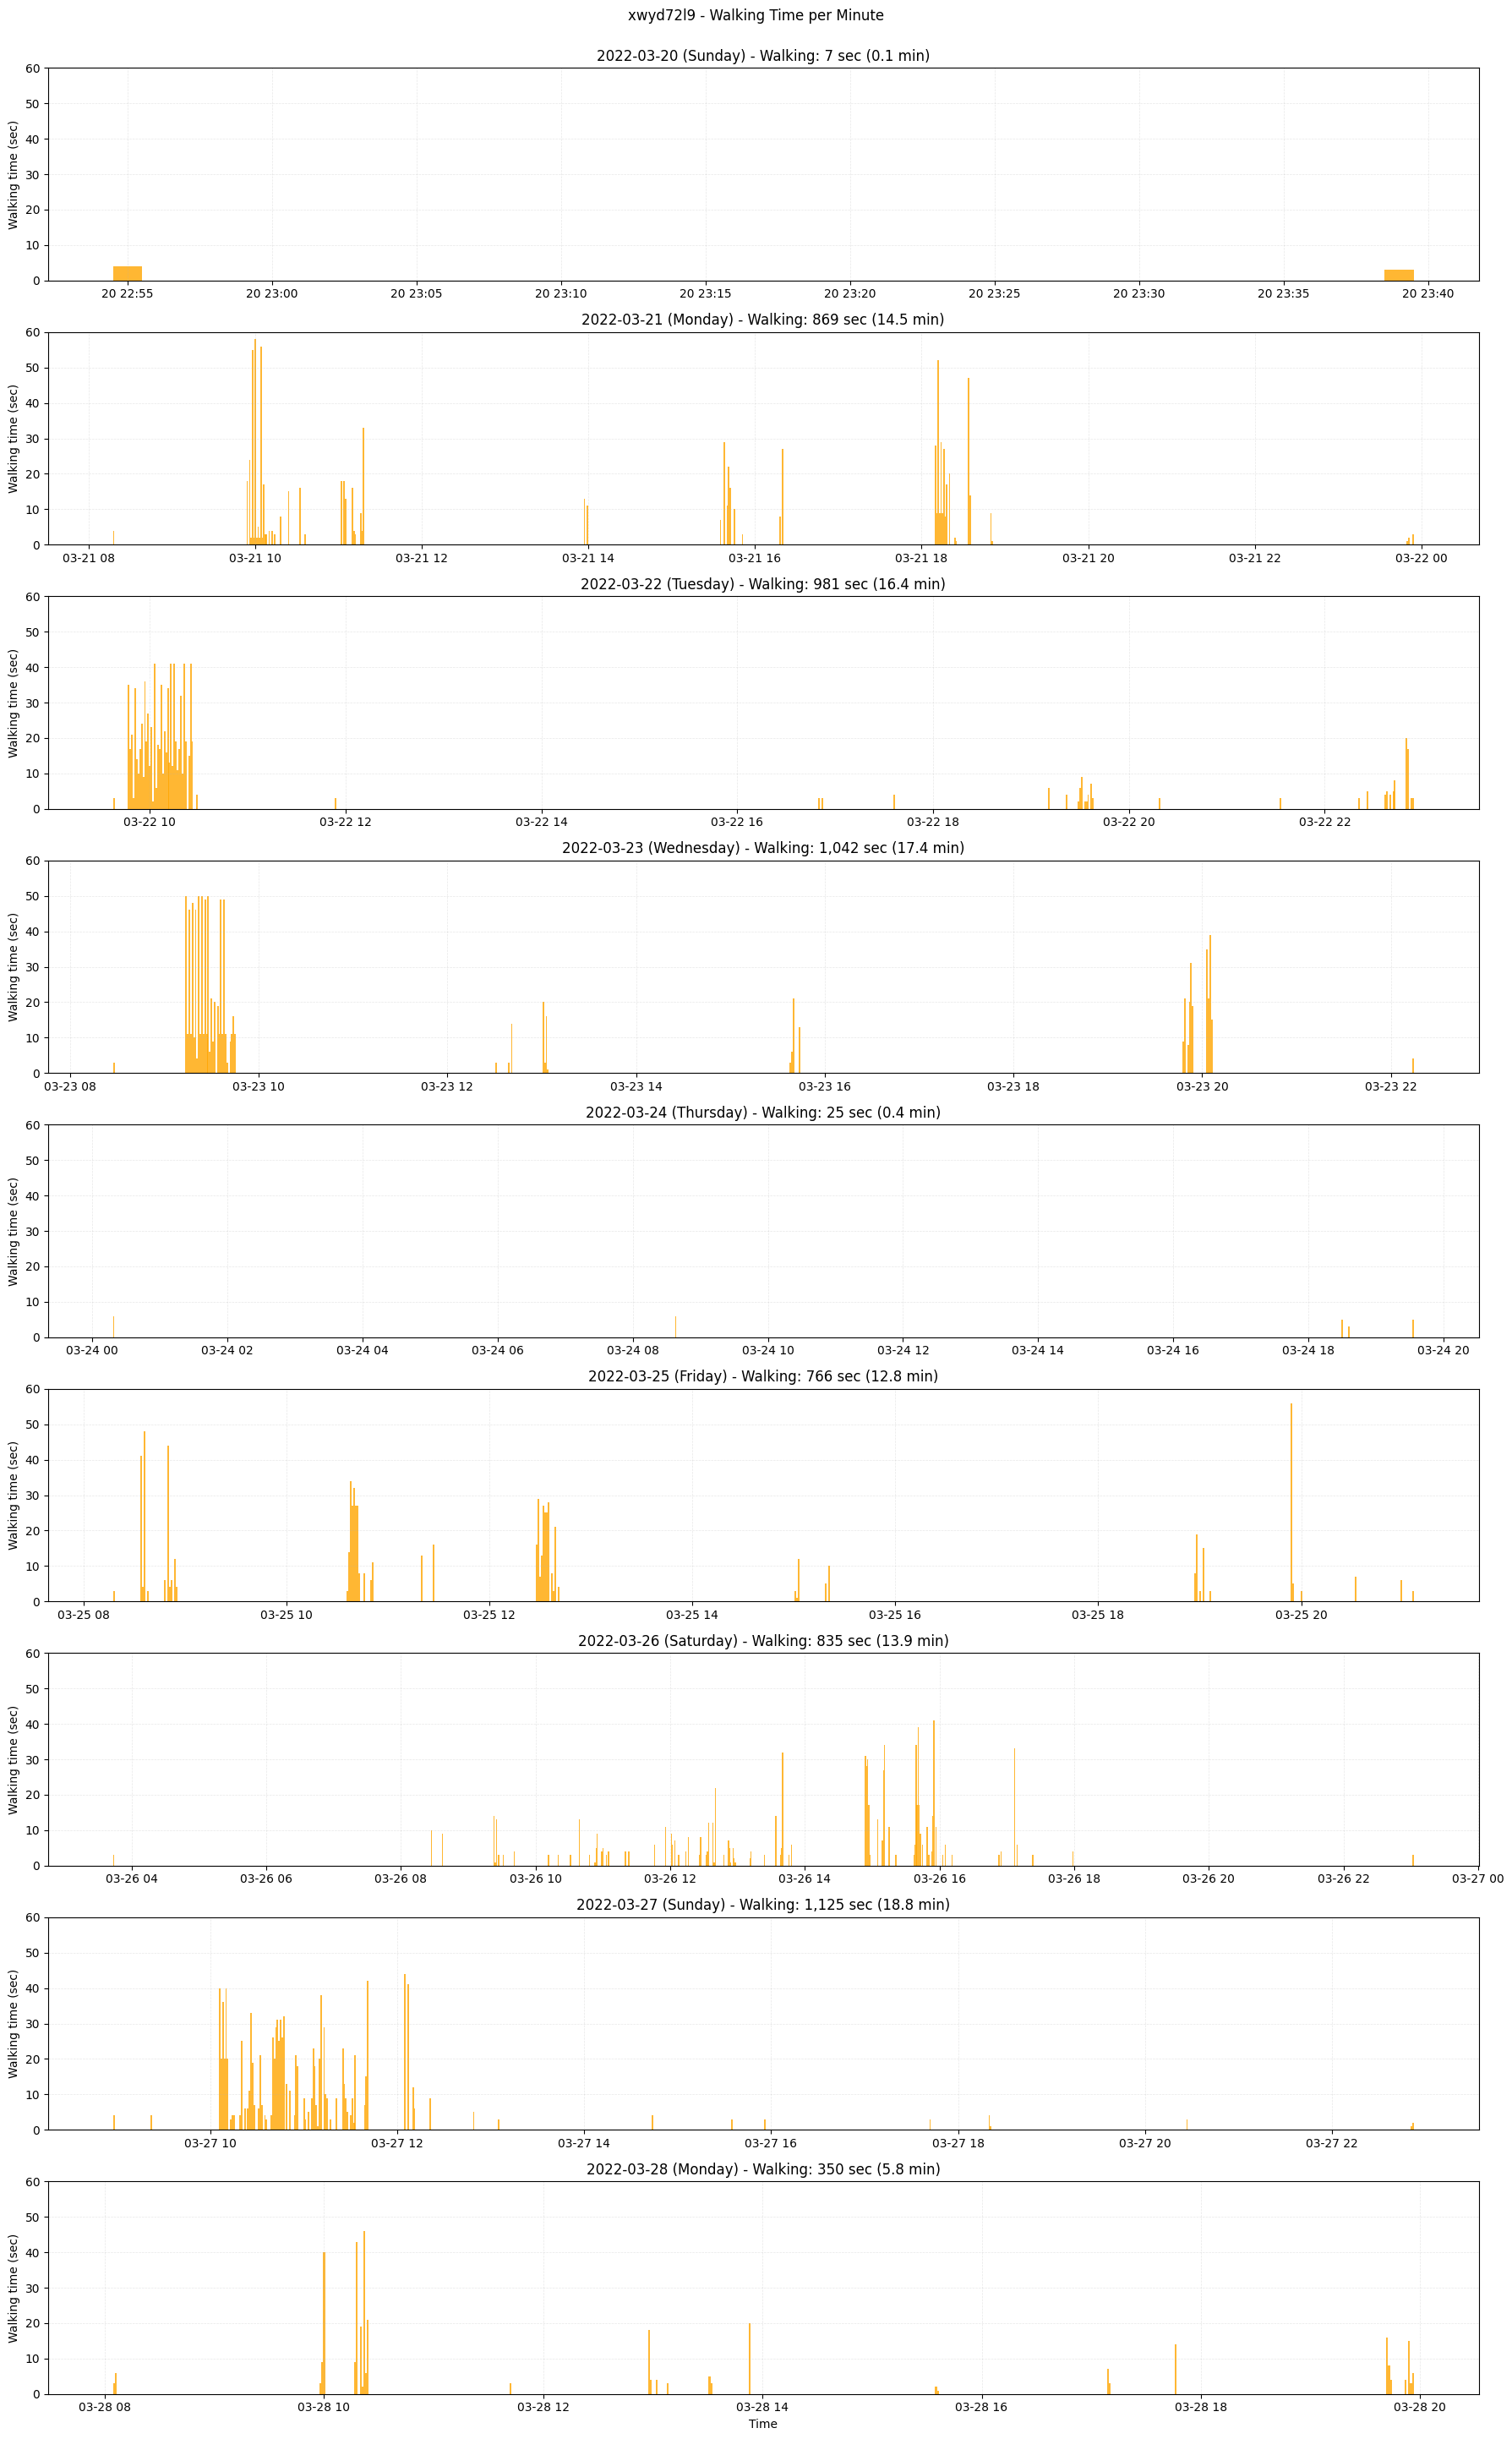

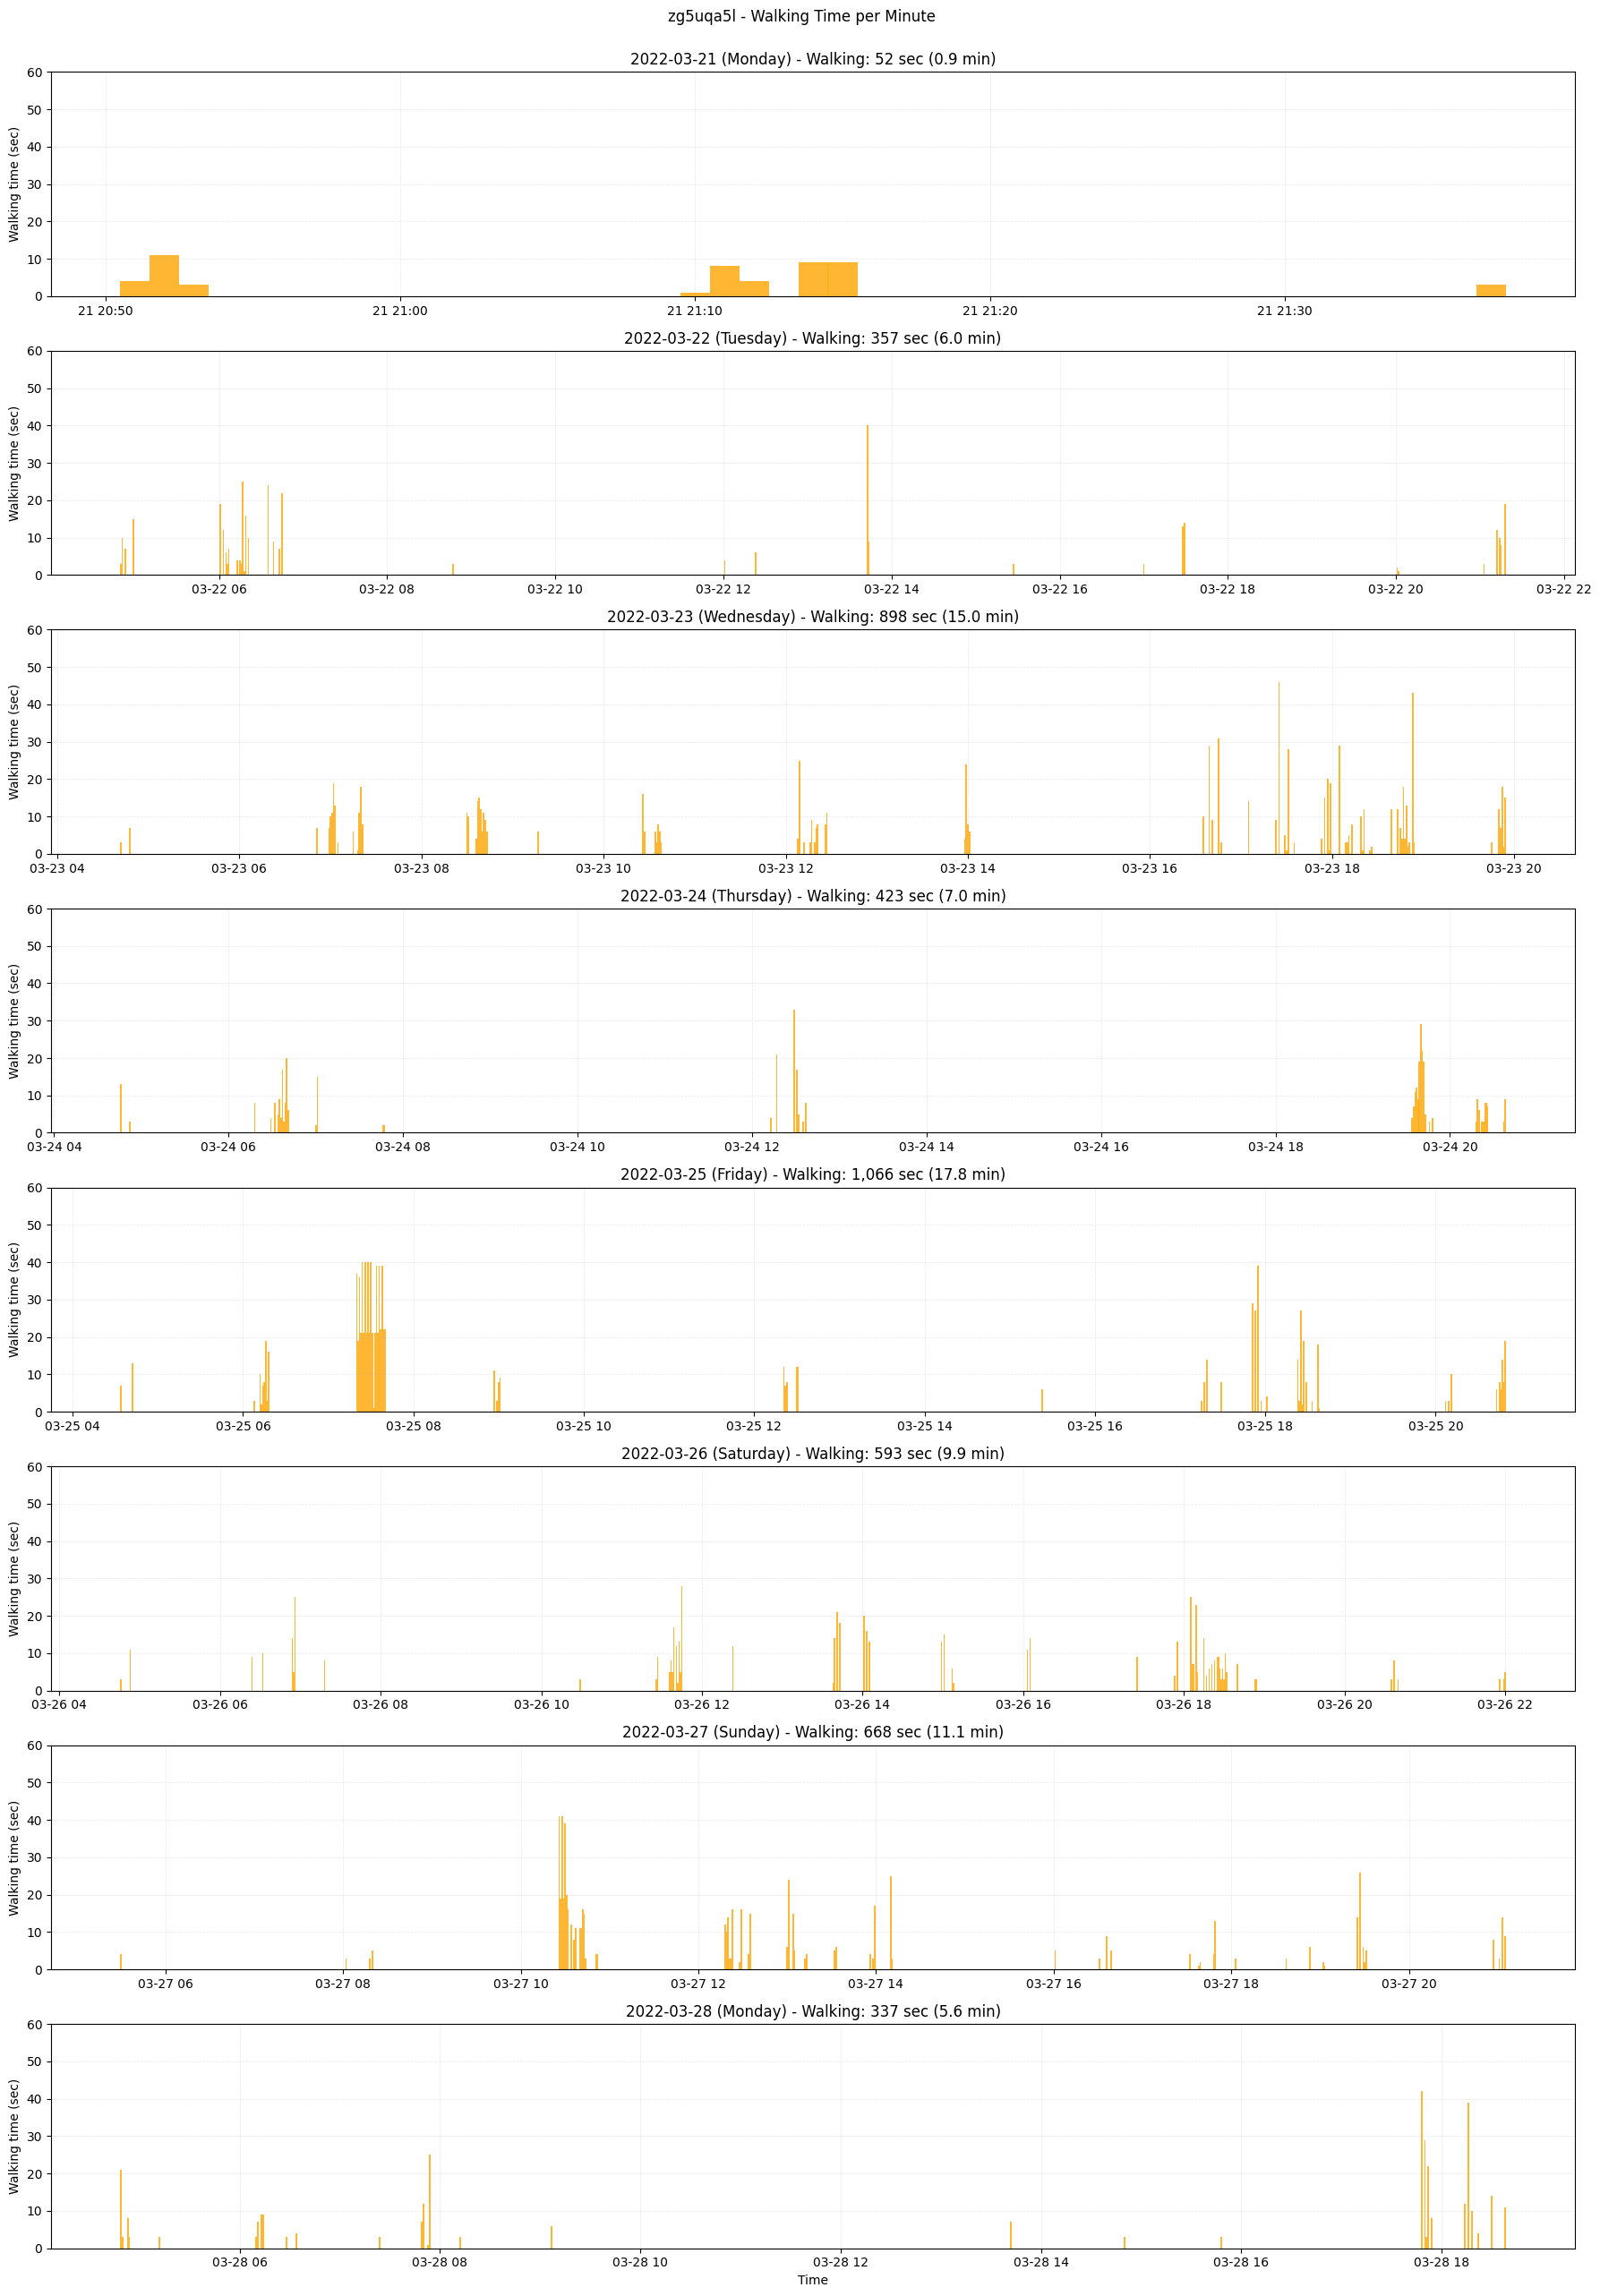

In [11]:
for subject_id, steps_df in subject_steps.items():
    # Filter to minutes with walking
    walking_df = steps_df[steps_df['walking_time'] > 0].copy()
    
    if walking_df.empty:
        print(f'{subject_id}: No walking detected.')
        continue
    
    walking_df['date'] = walking_df['timestamp'].dt.date
    unique_dates = sorted(walking_df['date'].unique())
    num_days = len(unique_dates)
    
    fig, axes = plt.subplots(num_days, 1, figsize=(18, 3.2 * num_days), sharex=False)
    if num_days == 1:
        axes = [axes]
    
    for ax, day in zip(axes, unique_dates):
        day_df = walking_df[walking_df['date'] == day]
        times = day_df['timestamp']
        
        ax.bar(times, day_df['walking_time'], width=0.0007, color='orange', alpha=0.8)
        
        weekday = pd.Timestamp(day).strftime('%A')
        daily_walking = day_df['walking_time'].sum()
        ax.set_title(f'{day} ({weekday}) - Walking: {daily_walking:,} sec ({daily_walking/60:.1f} min)')
        ax.set_ylabel('Walking time (sec)')
        ax.set_ylim(0, 60)
        ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)
    
    axes[-1].set_xlabel('Time')
    fig.suptitle(f'{subject_id} - Walking Time per Minute', y=1.0)
    plt.tight_layout()
    plt.savefig(f'../plots/{subject_id}_log_minutely_steps.png', bbox_inches='tight', dpi=200)
    plt.show()


## Setup Output Directory


In [ ]:
NOTEBOOK_DIR = Path('.').resolve()
INTERIM_DIR = (NOTEBOOK_DIR / '../data/interim').resolve()
INTERIM_DIR.mkdir(parents=True, exist_ok=True)
print(f'Interim directory: {INTERIM_DIR}')



=== 3si9xdvl Daily Summary ===
      date  total_steps  walking_minutes  avg_cadence  steps_per_min_walking
2022-03-21         1579        14.850000     1.803996             106.329966
2022-03-22          909         8.650000     1.802556             105.086705
2022-03-23            4         0.050000     1.483333              80.000000
2022-03-24         1172        11.333333     1.820886             103.411765
2022-03-25          444         4.216667     1.794869             105.296443
2022-03-26         5890        55.216667     1.839369             106.670691
2022-03-27          619         5.850000     1.832330             105.811966
2022-03-28            0         0.000000          NaN                    NaN

=== bn4j8yj9 Daily Summary ===
      date  total_steps  walking_minutes  avg_cadence  steps_per_min_walking
2022-03-21         1246        10.050000     1.977172             123.980100
2022-03-22          493         4.600000     1.817167             107.173913
2022-03-23  

## Compute and Save Hourly Aggregates


In [ ]:
# Compute hourly aggregates from minutely data
hourly_results: dict[str, pd.DataFrame] = {}

for subject_id, steps_df in subject_steps.items():
    df = steps_df.copy()
    
    # Floor timestamp to hour
    df['hour'] = df['timestamp'].dt.floor('H')
    
    # Aggregate by hour
    hourly_df = df.groupby('hour').agg(
        walking_time=('walking_time', 'sum'),  # Total seconds of walking in the hour
        steps=('steps', 'sum'),  # Total steps in the hour
        cadence=('cadence', lambda x: x[x > 0].mean() if (x > 0).any() else np.nan)  # Mean cadence when walking
    ).reset_index()
    
    hourly_df.rename(columns={'hour': 'timestamp'}, inplace=True)
    hourly_results[subject_id] = hourly_df
    
    # Save to CSV
    output_path = INTERIM_DIR / f'{subject_id}_steps_hourly.csv'
    hourly_df.to_csv(output_path, index=False, date_format='%Y-%m-%dT%H:%M:%S')
    print(f'Saved hourly data for {subject_id}: {len(hourly_df):,} hours -> {output_path}')

print(f'\nComputed hourly aggregates for {len(hourly_results)} participants.')


Interim directory: /n/home01/egraff/sample_imputation/data/interim


## Compute and Save Daily Aggregates


In [ ]:
# Compute daily aggregates from minutely data
daily_results: dict[str, pd.DataFrame] = {}

for subject_id, steps_df in subject_steps.items():
    df = steps_df.copy()
    
    # Get date from timestamp
    df['date'] = df['timestamp'].dt.date
    
    # Aggregate by day
    daily_df = df.groupby('date').agg(
        walking_time=('walking_time', 'sum'),  # Total seconds of walking in the day
        steps=('steps', 'sum'),  # Total steps in the day
        cadence=('cadence', lambda x: x[x > 0].mean() if (x > 0).any() else np.nan)  # Mean cadence when walking
    ).reset_index()
    
    daily_results[subject_id] = daily_df
    
    # Save to CSV
    output_path = INTERIM_DIR / f'{subject_id}_steps_daily.csv'
    daily_df.to_csv(output_path, index=False)
    print(f'Saved daily data for {subject_id}: {len(daily_df):,} days -> {output_path}')

print(f'\nComputed daily aggregates for {len(daily_results)} participants.')


## Daily Summary


In [ ]:
# Display daily summary for each participant
for subject_id, daily_df in daily_results.items():
    print(f'\n=== {subject_id} Daily Summary ===')
    
    # Convert walking_time from seconds to minutes for display
    summary_df = daily_df.copy()
    summary_df['walking_min'] = summary_df['walking_time'] / 60
    summary_df['steps_per_min'] = summary_df['steps'] / summary_df['walking_min']
    
    print(summary_df[['date', 'steps', 'walking_min', 'cadence', 'steps_per_min']].to_string(index=False))
    print(f"\nTotal steps: {daily_df['steps'].sum():,}")
    print(f"Total walking time: {daily_df['walking_time'].sum() / 60:.1f} minutes")


## Export Minutely Results to CSV


In [ ]:
STEPS_SUFFIX = 'steps'
export_paths: dict[str, Path] = {}

for subject_id, steps_df in subject_steps.items():
    export_path = INTERIM_DIR / f'{subject_id}_{STEPS_SUFFIX}.csv'
    steps_df.to_csv(export_path, index=False, date_format='%Y-%m-%dT%H:%M:%S.%f%z')
    export_paths[subject_id] = export_path
    print(f'Saved steps for {subject_id} -> {export_path}')

print(f'\nExported {len(export_paths)} files.')


Saved steps for 3si9xdvl -> /n/home01/egraff/sample_imputation/data/interim/3si9xdvl_steps.csv
Saved steps for bn4j8yj9 -> /n/home01/egraff/sample_imputation/data/interim/bn4j8yj9_steps.csv
Saved steps for gq36edfi -> /n/home01/egraff/sample_imputation/data/interim/gq36edfi_steps.csv
Saved steps for ubrmuu2r -> /n/home01/egraff/sample_imputation/data/interim/ubrmuu2r_steps.csv
Saved steps for xwyd72l9 -> /n/home01/egraff/sample_imputation/data/interim/xwyd72l9_steps.csv
Saved steps for zg5uqa5l -> /n/home01/egraff/sample_imputation/data/interim/zg5uqa5l_steps.csv

Exported 6 files.


## Cadence Distribution Analysis


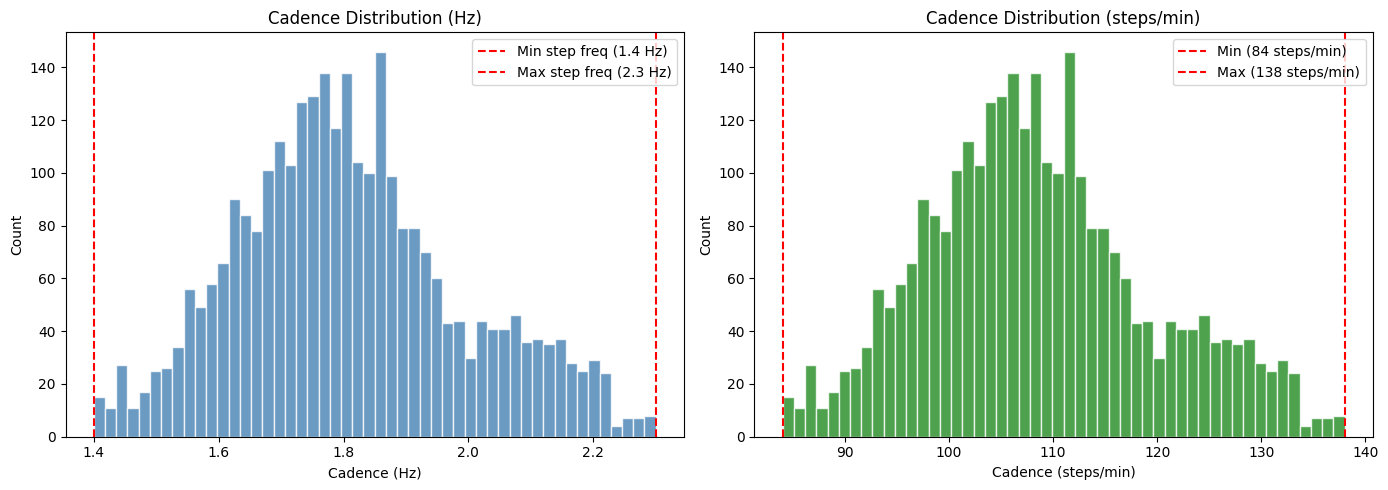

Mean cadence: 1.81 Hz (108.5 steps/min)
Median cadence: 1.79 Hz (107.5 steps/min)


In [15]:
# Combine all subjects for cadence analysis
all_cadence = []
for subject_id, steps_df in subject_steps.items():
    valid_cadence = steps_df.loc[steps_df['cadence'] > 0, 'cadence'].values
    all_cadence.extend(valid_cadence)

if all_cadence:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram in Hz
    axes[0].hist(all_cadence, bins=50, color='steelblue', edgecolor='white', alpha=0.8)
    axes[0].axvline(x=1.4, color='red', linestyle='--', label='Min step freq (1.4 Hz)')
    axes[0].axvline(x=2.3, color='red', linestyle='--', label='Max step freq (2.3 Hz)')
    axes[0].set_xlabel('Cadence (Hz)')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Cadence Distribution (Hz)')
    axes[0].legend()
    
    # Histogram in steps/min
    cadence_spm = [c * 60 for c in all_cadence]
    axes[1].hist(cadence_spm, bins=50, color='forestgreen', edgecolor='white', alpha=0.8)
    axes[1].axvline(x=84, color='red', linestyle='--', label='Min (84 steps/min)')
    axes[1].axvline(x=138, color='red', linestyle='--', label='Max (138 steps/min)')
    axes[1].set_xlabel('Cadence (steps/min)')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Cadence Distribution (steps/min)')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f'Mean cadence: {np.mean(all_cadence):.2f} Hz ({np.mean(all_cadence)*60:.1f} steps/min)')
    print(f'Median cadence: {np.median(all_cadence):.2f} Hz ({np.median(all_cadence)*60:.1f} steps/min)')
else:
    print('No walking detected across all subjects.')
